In [20]:
library(mgcv)
library(readxl)
library(ggplot2)
library(dplyr)
library(tibble)
library(lubridate)
library(tidyr)
library(purrr)
library(marginaleffects)
library(readr)
library(geosphere)
library(qs2)
library(cowplot)
library(magick)

options(repr.plot.width=15, repr.plot.height=8)
options('marginaleffects_posterior_interval' = 'hdi')

# Start and end dates for Active Streets Trial
AST = c(as.Date("2023-08-03"), as.Date("2024-07-24"))

# School Holidays
SCHOOL_HOL = list(
       interval(as.Date("2022-01-03"), as.Date("2022-01-04")),
       interval(as.Date("2022-02-18"), as.Date("2022-02-25")),
       interval(as.Date("2022-04-11"), as.Date("2022-04-22")),
       interval(as.Date("2022-05-30"), as.Date("2022-06-06")),
       interval(as.Date("2022-07-25"), as.Date("2022-09-01")),
                interval(as.Date("2022-10-24"), as.Date("2022-10-28")),
                interval(as.Date("2022-12-19"), as.Date("2023-01-02")),
                interval(as.Date("2023-02-13"), as.Date("2023-02-17")),
                interval(as.Date("2023-04-03"), as.Date("2023-04-14")),
                interval(as.Date("2023-05-01"), as.Date("2023-05-01")),
                interval(as.Date("2023-05-29"), as.Date("2023-06-02")),
                interval(as.Date("2023-07-26"), as.Date("2023-09-01")),
                interval(as.Date("2023-10-23"), as.Date("2023-10-27")),
                interval(as.Date("2023-12-18"), as.Date("2024-01-01")),
                interval(as.Date("2024-02-12"), as.Date("2024-02-16")),
                interval(as.Date("2024-03-29"), as.Date("2024-04-12")),
                interval(as.Date("2024-05-06"), as.Date("2024-05-06")),
                interval(as.Date("2024-05-27"), as.Date("2024-05-31")),
                interval(as.Date("2024-07-29"), as.Date("2024-09-02")),
                interval(as.Date("2024-10-28"), as.Date("2024-11-01")),
                interval(as.Date("2024-12-23"), as.Date("2025-01-03"))
)

# Bank Holidays: https://www.gov.uk/bank-holidays
BANK_HOLS = list(
       interval(as.Date("2022-01-03"), as.Date("2022-01-03")),
       interval(as.Date("2022-04-15"), as.Date("2022-04-18")),
       interval(as.Date("2022-05-02"), as.Date("2022-05-02")),
       interval(as.Date("2022-06-02"), as.Date("2022-06-03")),
       interval(as.Date("2022-08-29"), as.Date("2022-08-29")),
       interval(as.Date("2022-09-19"), as.Date("2022-09-19")),
                interval(as.Date("2022-12-26"), as.Date("2022-12-27")),
                interval(as.Date("2023-01-02"), as.Date("2023-01-02")),
                interval(as.Date("2023-04-07"), as.Date("2023-04-10")),
                interval(as.Date("2023-05-01"), as.Date("2023-05-01")),
                interval(as.Date("2023-05-08"), as.Date("2023-05-08")),
                interval(as.Date("2023-05-29"), as.Date("2023-05-29")),
                interval(as.Date("2023-08-28"), as.Date("2023-08-28")),
                interval(as.Date("2023-12-25"), as.Date("2023-12-26")),
                interval(as.Date("2024-01-01"), as.Date("2024-01-01")),
                interval(as.Date("2024-03-29"), as.Date("2024-04-01")),
                interval(as.Date("2024-05-06"), as.Date("2024-05-06")),
                interval(as.Date("2024-05-27"), as.Date("2024-05-27")),
                interval(as.Date("2024-08-26"), as.Date("2024-08-26")),
                interval(as.Date("2024-12-25"), as.Date("2024-12-26"))
                )

# British Summer Time dates
BST = list(interval(as.Date("2022-03-27"), as.Date("2022-10-30")),
            interval(as.Date("2023-03-26"), as.Date("2023-10-29")),
            interval(as.Date("2024-03-31"), as.Date("2024-10-27"))
            )

# Load rainfall data
tp <- read_delim(file = 'data/exeter_rainfall.csv', delim=' ', show_col_types = FALSE) %>% 
       select(date, value) %>%
       rename(Date = date, rain = value) %>%
       mutate(rain = rain*1e3) %>% # Convert rainfall total to mm
       replace(is.na(.), 0)

New names:
• `` -> `...1`
• `` -> `...4`
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


In [3]:
# Supplementary Data 2022-2024: Sensors 2022-2024.xlsx
lsr_names = c("Ladysmith Rd 22", 
            "Ladysmith Rd 23",
            "Ladysmith Rd 24")

pr_names = c("Park Rd 22", 
            "Park Rd 23",
            "Park Road 24")

hl_names = c("Hamlin Ln 22", 
            "Hamlin Ln 23",
            "Hamlin Ln 24")

rc_names = c("Roseland Cres 22", 
            "Roseland Cres 23",
            "Roseland Cres 24")

vr_names = c("Vaughan Rd 22", 
            "Vaughan Rd 23",
            "Vaughan Rd 24")
 
 tr_names = c("Thornpark Rs 22", 
            "Thornpark Rs 23",
            "Thornpark Rs 24",
            "Tpark Rs LHS 22",
            "Tpark Rs LHS 23",
            "Tpark Rs LHS 24",
            "Tpark Rs RHS 22",
            "Tpark Rs RHS 23",
            "Tpark Rs RHS 24")

sheets <- list("Ladysmith Road"=lsr_names, 
                  "Park Road"=pr_names, 
                  "Hamlin Lane"=hl_names, 
                  "Roseland Crescent"=rc_names, 
                  "Vaughan Road"=vr_names, 
                  "Thornpark Road"=tr_names
              )

df2 <- purrr::map_dfr(names(sheets), function(x){
       df <- bind_rows(lapply(sheets[[x]], FUN = read_excel, path="./data/Sensors 2022-2024.xlsx"))
       df %>% mutate(Date = as.Date(`Local Datetime`), location=as.factor(x), mode="Cyclist", Sensor=as.factor("Vivacity")) %>%
       select(-c(`UTC Datetime`, `Local Datetime`, countlineName, direction)) %>%
       rename(count=Cyclist)
})


In [113]:
# Supplementary Data 2022-2024: Sensors 2022-2024.xlsx
atc11 = c("Site 11 22", 
          "Site 11 23",
          "Site 11 24")

atc34 = c("Site 34 22", 
          "Site 34 23",
          "Site 34 24")

atc876 = c("Site 876 22", 
          "Site 876 23",
          "Site 876 24")

atc33 = c("Site 33 22", 
          "Site 33 23",
          "Site 33 24")

atc31 = c("Site 31 22", 
          "Site 31 23",
          "Site 31 24")

atc21 = c("Site 21 22", 
          "Site 21 23",
          "Site 21 24")

atc17 = c("Site 17 22", 
          "Site 17 23",
          "SIte 17 24")  # sic

atc6 = c("Site 6 22", 
          "SIte 6 23",  # sic
          "Site 6 24")

atc3 = c("Site 3 22", 
          "SIte 3 23",  # sic
          "SIte 3 24")  # sic

atc30 = c("Site 30 22", 
          "Site 30 23",
          "Site 30 24")

atc36 = c("Site 36 22", 
          "Site 36 23",
          "Site 36 24")

sheets <- list("Prince Charles Road"=atc11,
"Triangle Car Park"=atc34,
"Hamlin Lane Playing Fields"=atc876,
"Redhayes Bridge"=atc33,
"Haven Banks"=atc31,
"Sowton Digby Railway Link"=atc21,
"Riverside Valley Park"=atc17,
"Rydon Lane North"=atc6,
"Rydon Lane South"=atc3,
"Exminster Canal Causeway"=atc30,
"Exeter Road, Topsham"=atc36)

df3 <- purrr::map_dfr(names(sheets), function(x){
       df <- bind_rows(lapply(sheets[[x]], FUN = read_excel, path="./data/Sensors 2022-2024.xlsx", range="A15:NF39"))
       df %>% pivot_longer(cols=starts_with("20"), values_to = "count", values_drop_na = FALSE, names_to = "Date") %>%
       mutate(location=as.factor(x), mode="Cyclist", Date=as.Date(Date), Time=`...1`) %>%
       select(-c("Workday",	"7 Day", "Count", starts_with("..."))) %>% 
       group_by(Date, location, mode) %>% summarise(count=sum(count, na.rm = TRUE)) %>%
       mutate(Sensor=as.factor("ATC"))
       })

New names:
• `` -> `...1`
• `` -> `...370`
New names:
• `` -> `...1`
• `` -> `...370`
New names:
• `` -> `...1`
• `` -> `...315`
• `` -> `...316`
• `` -> `...317`
• `` -> `...318`
• `` -> `...319`
• `` -> `...320`
• `` -> `...321`
• `` -> `...322`
• `` -> `...323`
• `` -> `...324`
• `` -> `...325`
• `` -> `...326`
• `` -> `...327`
• `` -> `...328`
• `` -> `...329`
• `` -> `...330`
• `` -> `...331`
• `` -> `...332`
• `` -> `...333`
• `` -> `...334`
• `` -> `...335`
• `` -> `...336`
• `` -> `...337`
• `` -> `...338`
• `` -> `...339`
• `` -> `...340`
• `` -> `...341`
• `` -> `...342`
• `` -> `...343`
• `` -> `...344`
• `` -> `...345`
• `` -> `...346`
• `` -> `...347`
• `` -> `...348`
• `` -> `...349`
• `` -> `...350`
• `` -> `...351`
• `` -> `...352`
• `` -> `...353`
• `` -> `...354`
• `` -> `...355`
• `` -> `...356`
• `` -> `...357`
• `` -> `...358`
• `` -> `...359`
• `` -> `...360`
• `` -> `...361`
• `` -> `...362`
• `` -> `...363`
• `` -> `...364`
• `` -> `...365`
• `` -> `...366`
• ``

In [4]:
df <- rbind(df2, df3) %>%
       mutate(weekday = wday(Date, week_start = 1),
                     Date = as.Date(Date),
                     doy = yday(Date),
                     ast.3bool = case_when(Date < AST[1] ~ as.factor('Before'),
                                          Date <= AST[2] & Date >= AST[1] ~ as.factor('During'), 
                                          Date > AST[2] ~ as.factor('After')),
                     ast.2bool = case_when(Date < AST[1] ~ as.factor('No'),
                                          Date <= AST[2] & Date >= AST[1] ~ as.factor('Yes'), 
                                          Date > AST[2] ~ as.factor('No')),
                     school.hol = as.factor(0),
                     year = year(Date)-min(year(Date)))

# Sum multiple Thornpark Rise sheets
df <- df %>% group_by(Date, location, mode) %>% mutate(count = sum(count)) %>% ungroup() %>% distinct()

# Add school holiday indicator
df <- df %>% mutate(school.hol = if_else(Date %within% SCHOOL_HOL, as.factor(1), as.factor(0))) %>%
       # Add British Summer Time indicator
       mutate(bst.bool = if_else(Date %within% BST, as.factor('BST'), as.factor('UTC'))) %>%
       # Add Length of Day
        mutate(lod = daylength(lat = 50.7290, doy)) %>%
       # Add Bank Holiday indicator
       mutate(bankhol.bool = if_else(Date %within% BANK_HOLS, as.factor(1), as.factor(0))) %>%
       #Add rainfall
       left_join(tp)

qs_save(df, file="24hr.cycle.2022-2024.qs2")

ERROR: Error: object 'df3' not found


In [4]:
df <- qs_read(file="24hr.cycle.2022-2024.qs2")
head(df)

count Date       location       mode    Sensor   weekday doy ast.3bool
1  54   2022-09-09 Ladysmith Road Cyclist Vivacity 5       252 Before   
2  57   2022-09-10 Ladysmith Road Cyclist Vivacity 6       253 Before   
3  60   2022-09-11 Ladysmith Road Cyclist Vivacity 7       254 Before   
4  92   2022-09-12 Ladysmith Road Cyclist Vivacity 1       255 Before   
5  81   2022-09-13 Ladysmith Road Cyclist Vivacity 2       256 Before   
6 128   2022-09-14 Ladysmith Road Cyclist Vivacity 3       257 Before   
  ast.2bool school.hol year bst.bool lod      bankhol.bool rain      
1 No        0          0    BST      13.10223 0             2.3080910
2 No        0          0    BST      13.03944 0             0.4302237
3 No        0          0    BST      12.97656 0             1.7909230
4 No        0          0    BST      12.91360 0             5.0449330
5 No        0          0    BST      12.85055 0            20.6240800
6 No        0          0    BST      12.78744 0            14.4839200

Check for very high a very low values (outliers):

* High outliers based on values that are greater than 3 std away from the median
* Low outliers based on zero counts that persists for more than 1 day

In [5]:
df.hiout <- df %>% group_by(location) %>% summarise(oob = median(count) + 3*var(count)**0.5)
df.hiout
# Filter high outliers
df <- df %>% left_join(df.hiout) %>% filter(count < oob)

location                   oob       
1  Ladysmith Road              225.05587
2  Park Road                   234.30984
3  Hamlin Lane                 189.92956
4  Roseland Crescent           336.95710
5  Vaughan Road                494.42819
6  Thornpark Road              245.42383
7  Prince Charles Road         366.83142
8  Triangle Car Park           165.52576
9  Hamlin Lane Playing Fields  341.85653
10 Redhayes Bridge             337.43894
11 Haven Banks                1951.74497
12 Sowton Digby Railway Link   261.68683
13 Riverside Valley Park      1936.64086
14 Rydon Lane North             90.44832
15 Rydon Lane South            397.27511
16 Exminster Canal Causeway   1198.93248
17 Exeter Road, Topsham        786.53988

Joining with `by = join_by(location)`


In [6]:
# Filter consecutive zero outliers
rle_length = rle(df$count)$lengths
df <- df %>% group_by(location) %>% mutate(rle_len = unlist(lapply(1:length(rle(count)$length), function(i) rep(rle(count)$length[i], rle(count)$length[i]))))
df <- df %>% filter(count != 0 & rle_len < 2)

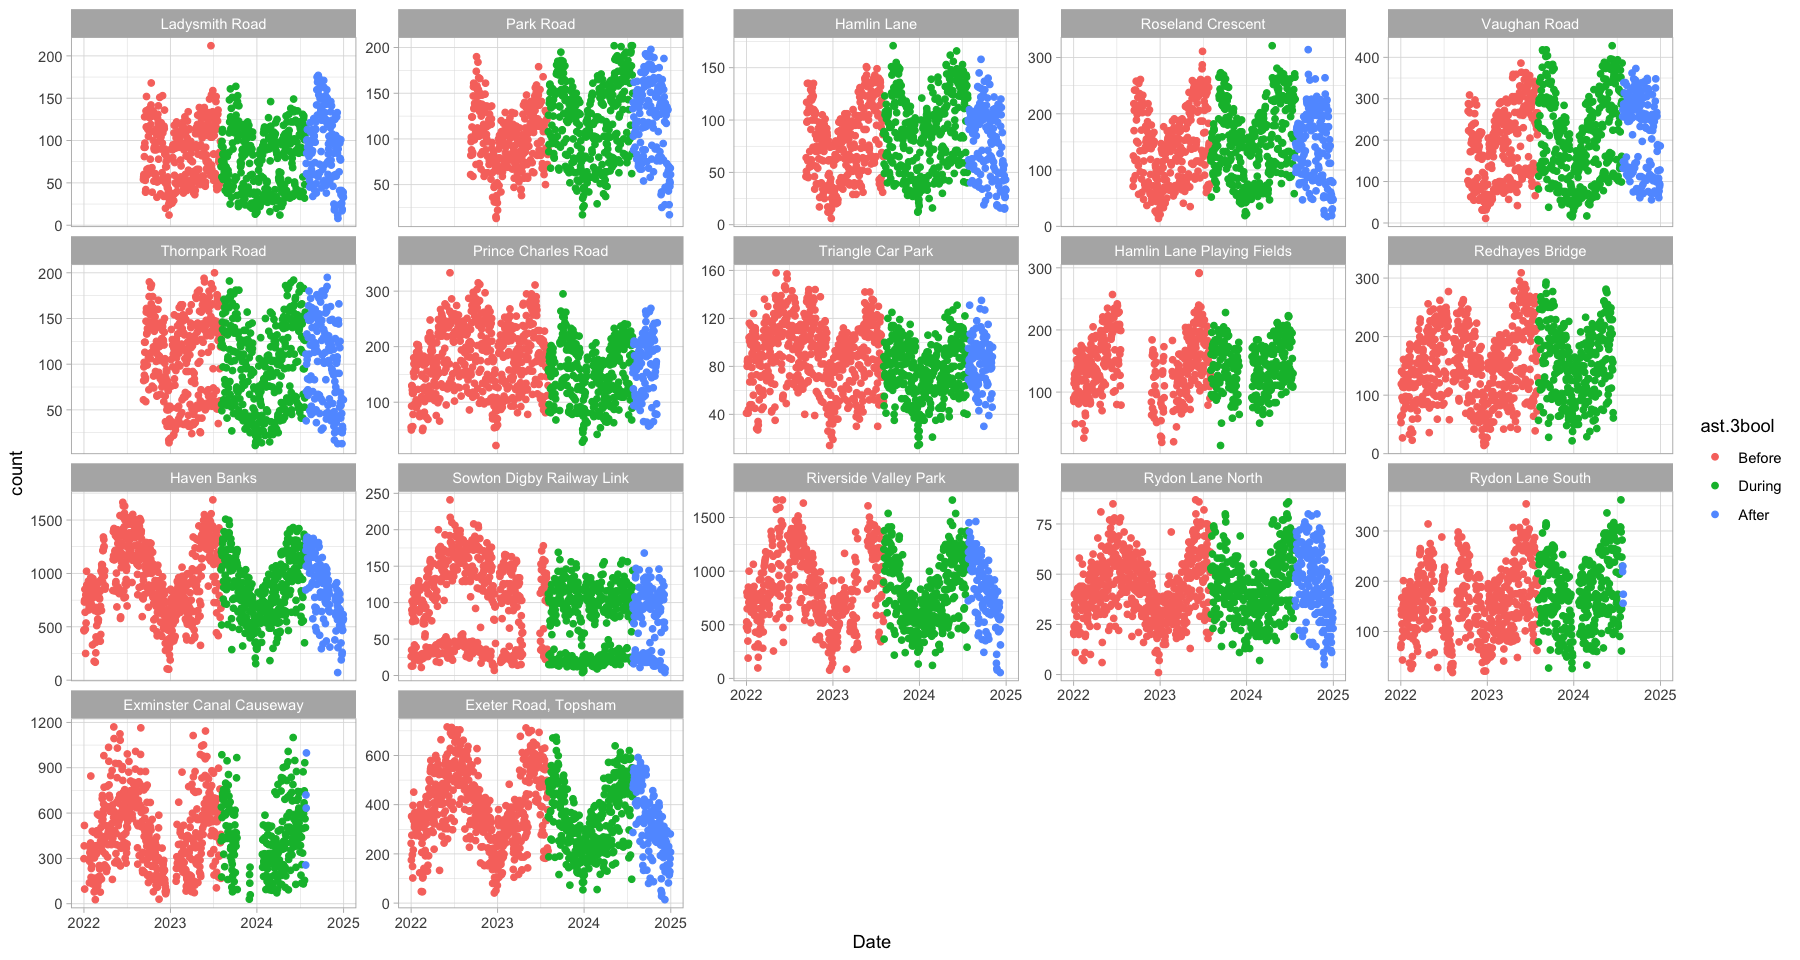

In [7]:
ggplot(data = df %>% filter(mode=='Cyclist'), aes(x=Date, y=count, colour=ast.3bool)) + 
    geom_point() + 
    # annotate("rect", xmin = AST[1], xmax = AST[2], ymin = -1, ymax = 500,
    #          alpha = 0, color= "red") +
    facet_wrap(~location, scales = "free_y") +
    theme_light()

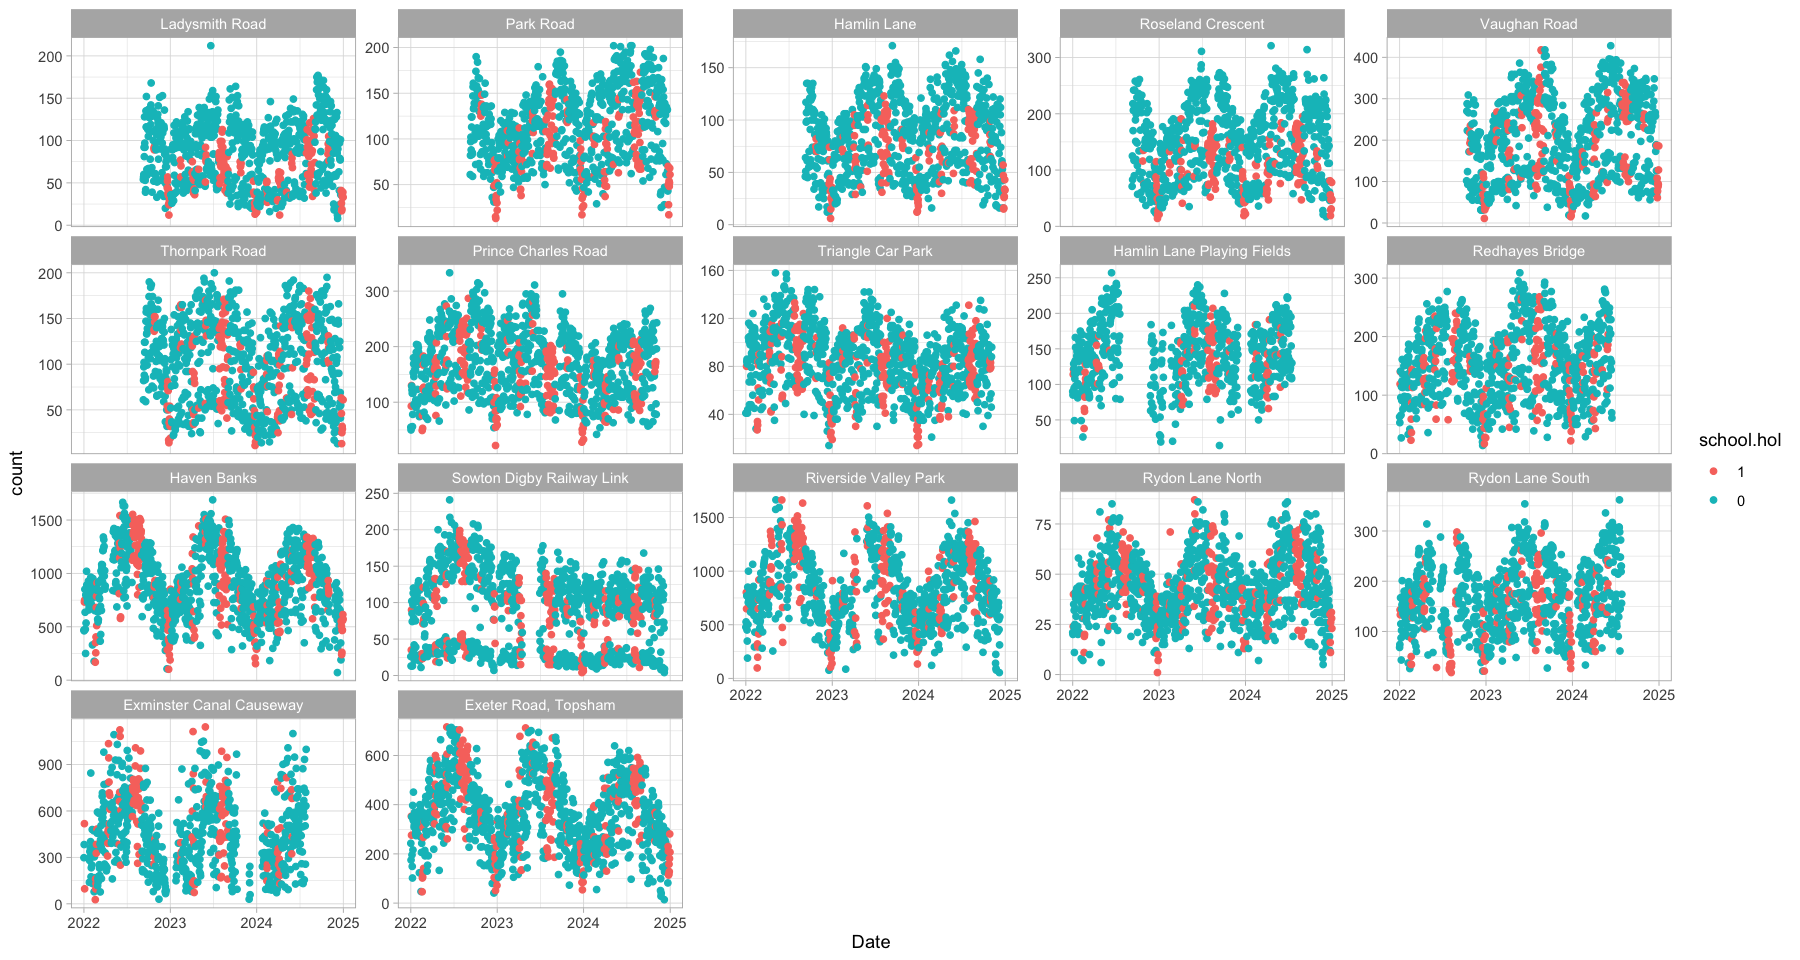

In [12]:
ggplot(data = df %>% filter(mode=='Cyclist'), aes(x=Date, y=count, color=school.hol)) + 
    geom_point() + 
    facet_wrap(~location, scales = "free_y") +
    theme_light()

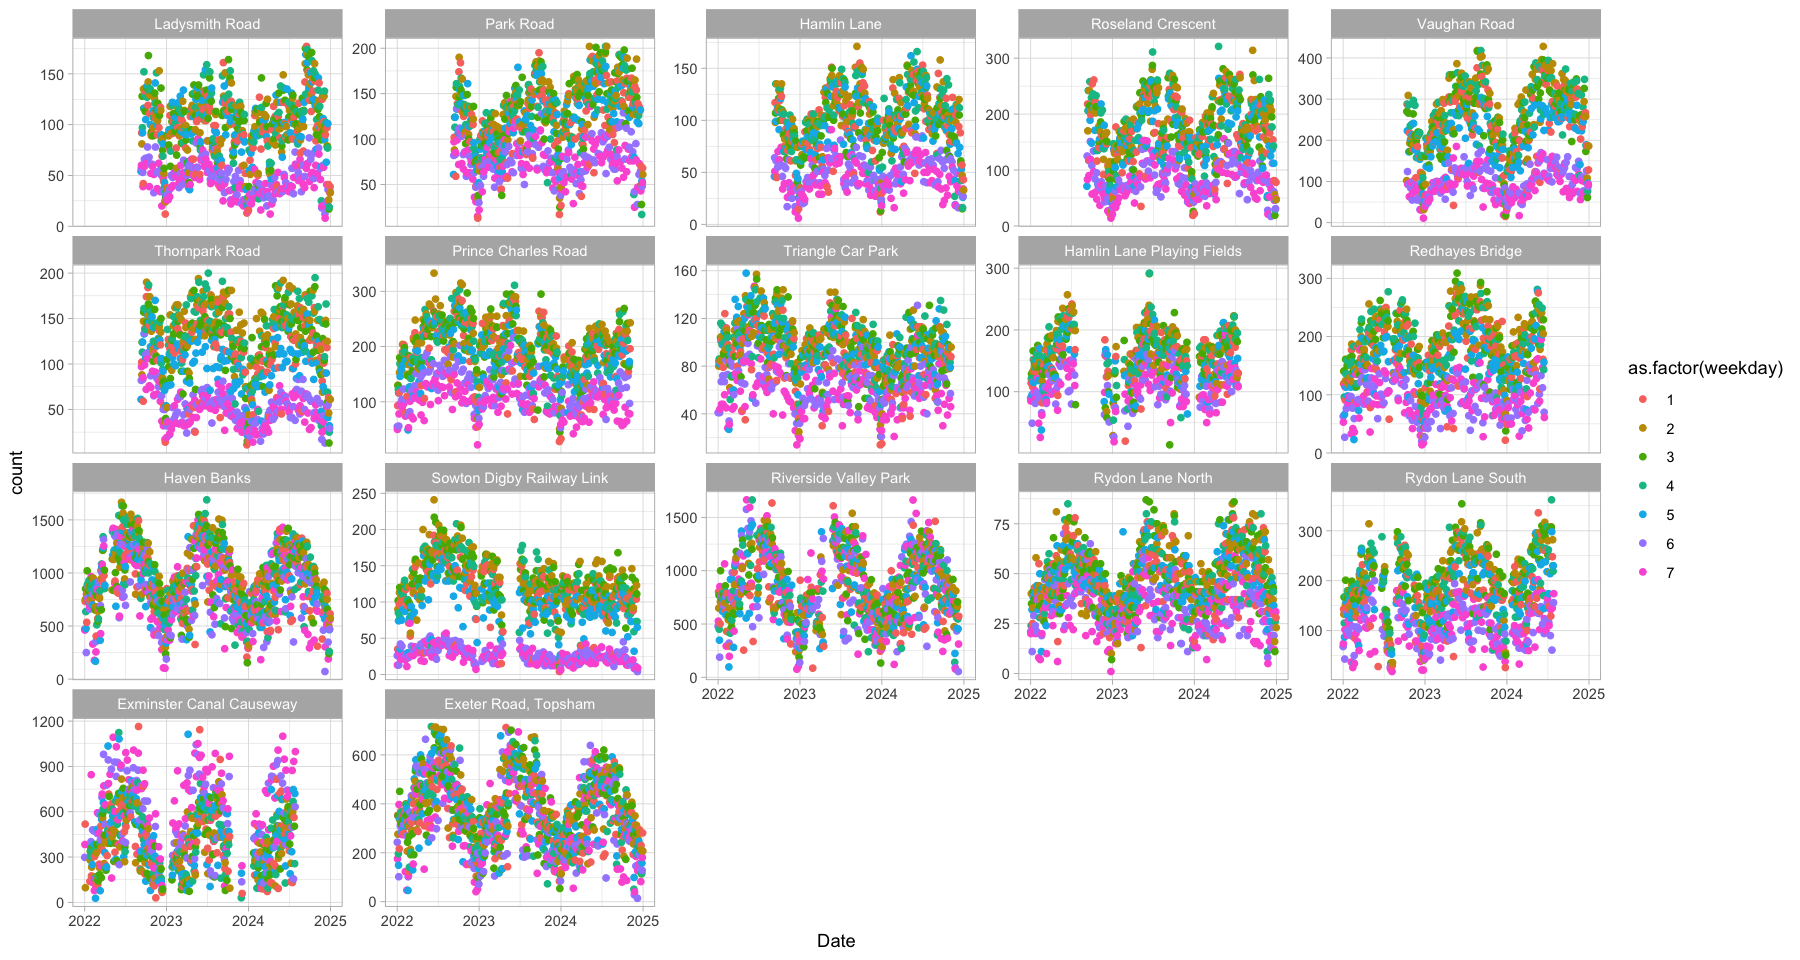

In [155]:
ggplot(data = df %>% filter(mode=='Cyclist'), aes(x=Date, y=count, color=as.factor(weekday))) + 
    geom_point() + 
    facet_wrap(~location, scales = "free_y") +
    theme_light()

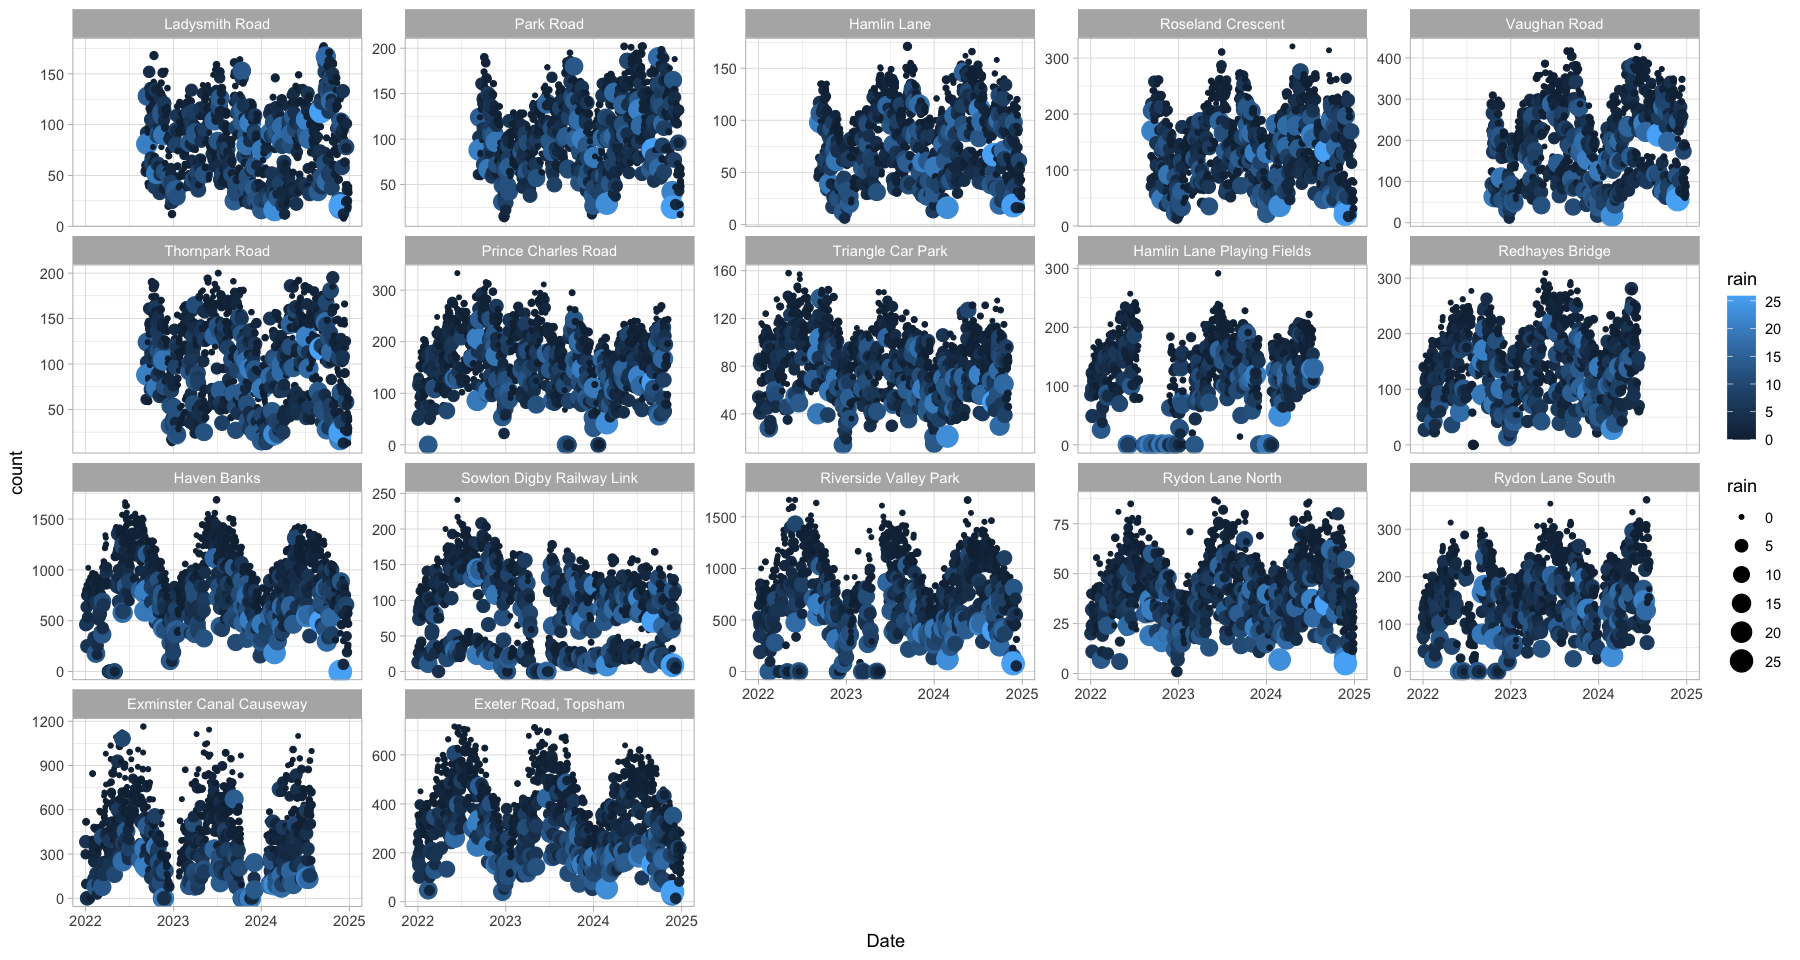

In [92]:
ggplot(data = df %>% filter(mode=='Cyclist'), aes(x=Date, y=count, size=rain, color=rain)) + 
    geom_point() + 
    facet_wrap(~location, scales = "free_y") +
    theme_light()

In [140]:
df %>% filter(rain == 0 & school.hol == 0 & mode == 'Cyclist')

Date       weekday doy ast.3bool ast.2bool location       school.hol year
1   2022-09-17 6       260 Before    No        Ladysmith Road 0          0   
2   2022-12-15 4       349 Before    No        Ladysmith Road 0          0   
3   2022-12-16 5       350 Before    No        Ladysmith Road 0          0   
4   2023-01-20 5        20 Before    No        Ladysmith Road 0          1   
5   2023-01-23 1        23 Before    No        Ladysmith Road 0          1   
6   2023-04-20 4       110 Before    No        Ladysmith Road 0          1   
7   2023-04-25 2       115 Before    No        Ladysmith Road 0          1   
8   2023-05-21 7       141 Before    No        Ladysmith Road 0          1   
9   2023-05-22 1       142 Before    No        Ladysmith Road 0          1   
10  2023-05-26 5       146 Before    No        Ladysmith Road 0          1   
11  2023-05-27 6       147 Before    No        Ladysmith Road 0          1   
12  2023-06-04 7       155 Before    No        Ladysmith Road 0          1   
13  2023-06-06 2       157 Before    No        Ladysmith Road 0          1   
14  2023-06-14 3       165 Before    No        Ladysmith Road 0          1   
15  2023-06-15 4       166 Before    No        Ladysmith Road 0          1   
16  2023-09-04 1       247 During    Yes       Ladysmith Road 0          1   
17  2023-09-06 3       249 During    Yes       Ladysmith Road 0          1   
18  2023-10-09 1       282 During    Yes       Ladysmith Road 0          1   
19  2023-10-15 7       288 During    Yes       Ladysmith Road 0          1   
20  2024-01-18 4        18 During    Yes       Ladysmith Road 0          2   
21  2024-01-19 5        19 During    Yes       Ladysmith Road 0          2   
22  2024-09-14 6       258 After     No        Ladysmith Road 0          2   
23  2024-09-17 2       261 After     No        Ladysmith Road 0          2   
24  2022-09-17 6       260 Before    No        Park Road      0          0   
25  2022-12-15 4       349 Before    No        Park Road      0          0   
26  2022-12-16 5       350 Before    No        Park Road      0          0   
27  2023-01-20 5        20 Before    No        Park Road      0          1   
28  2023-01-23 1        23 Before    No        Park Road      0          1   
29  2023-04-20 4       110 Before    No        Park Road      0          1   
30  2023-04-25 2       115 Before    No        Park Road      0          1   
⋮   ⋮          ⋮       ⋮   ⋮         ⋮         ⋮              ⋮          ⋮   
104 2023-09-04 1       247 During    Yes       Vaughan Road   0          1   
105 2023-09-06 3       249 During    Yes       Vaughan Road   0          1   
106 2023-10-09 1       282 During    Yes       Vaughan Road   0          1   
107 2023-10-15 7       288 During    Yes       Vaughan Road   0          1   
108 2024-01-18 4        18 During    Yes       Vaughan Road   0          2   
109 2024-01-19 5        19 During    Yes       Vaughan Road   0          2   
110 2024-09-14 6       258 After     No        Vaughan Road   0          2   
111 2024-09-17 2       261 After     No        Vaughan Road   0          2   
112 2022-12-15 4       349 Before    No        Thornpark Road 0          0   
113 2022-12-16 5       350 Before    No        Thornpark Road 0          0   
114 2023-01-20 5        20 Before    No        Thornpark Road 0          1   
115 2023-01-23 1        23 Before    No        Thornpark Road 0          1   
116 2023-04-20 4       110 Before    No        Thornpark Road 0          1   
117 2023-04-25 2       115 Before    No        Thornpark Road 0          1   
118 2023-05-21 7       141 Before    No        Thornpark Road 0          1   
119 2023-05-22 1       142 Before    No        Thornpark Road 0          1   
120 2023-05-26 5       146 Before    No        Thornpark Road 0          1   
121 2023-05-27 6       147 Before    No        Thornpark Road 0          1   
122 2023-06-04 7       155 Before    No        Thornpark Road 0          1   
123 2023-06-06 2       157

In [53]:
df %>% filter(rain > 0) %>% summarise(mean(rain))

location                   mean(rain)
1  Ladysmith Road             2.911838  
2  Park Road                  2.911538  
3  Hamlin Lane                2.878007  
4  Roseland Crescent          2.854777  
5  Vaughan Road               2.886427  
6  Thornpark Road             2.884689  
7  Prince Charles Road        2.731031  
8  Triangle Car Park          2.650450  
9  Hamlin Lane Playing Fields 2.506699  
10 Redhayes Bridge            2.696706  
11 Haven Banks                2.697756  
12 Sowton Digby Railway Link  2.810184  
13 Riverside Valley Park      2.807206  
14 Rydon Lane North           2.722559  
15 Rydon Lane South           2.598970  
16 Exminster Canal Causeway   2.422145  
17 Exeter Road, Topsham       2.671122

## Model Fitting

In [ ]:
nb.m3 <- gam(count ~ s(location, bs="re") + 
                s(weekday, location, bs='fs', xt=list(bs="tp"), k=7) + 
                s(ast.3bool, by=location, bs='re') + 
                s(school.hol, bs='re') +
                s(bst.bool, bs='re') +
                s(bankhol.bool, bs='re') +
                s(doy, bs = 'cc', k=14) +
                s(rain, bs='tp', k=12),
            data = df2,
            family = nb, method='REML')

Warning message in gam.side(sm, X, tol = .Machine$double.eps^0.5):
“model has repeated 1-d smooths of same variable.”


In [179]:
nb.m5 <- gam(count ~ s(Sensor, bs="re") + s(location, bs="re") + 
                s(weekday, by=location, bs='tp', k=7) + 
                s(ast.3bool, by=location, bs='re') + 
                s(school.hol, by=location, bs='re') +
                s(bankhol.bool, bs='re') +
                te(rain, doy, bs=c('tp', 'cc'), k=c(4, 14)),
            data = df,
            family = nb, method='REML')


In [ ]:
qs_save(nb.m5, "Rdata/gam.nb.cycles.2022-2024.qs2")

In [ ]:
nb.m5 <- qs_read("Rdata/gam.nb.cycles.2022-2024.qs2")

In [14]:
summary(nb.m5)


Family: Negative Binomial(19.005) 
Link function: log 

Formula:
count ~ s(location, bs = "re") + s(weekday, by = location, bs = "tp", 
    k = 7) + s(ast.3bool, by = location, bs = "re") + s(school.hol, 
    by = location, bs = "re") + s(bankhol.bool, bs = "re") + 
    te(rain, doy, bs = c("tp", "cc"), k = c(4, 14))

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)    4.885      0.239   20.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                                      edf Ref.df    Chi.sq
s(location)                                      15.64846 16.000 1.223e+07
s(weekday):locationLadysmith Road                 5.89137  5.995 1.479e+03
s(weekday):locationPark Road                      5.77272  5.979 7.093e+02
s(weekday):locationHamlin Lane                    5.80871  5.985 1.318e+03
s(weekday):locationRoseland Crescent              5.85191  5.99

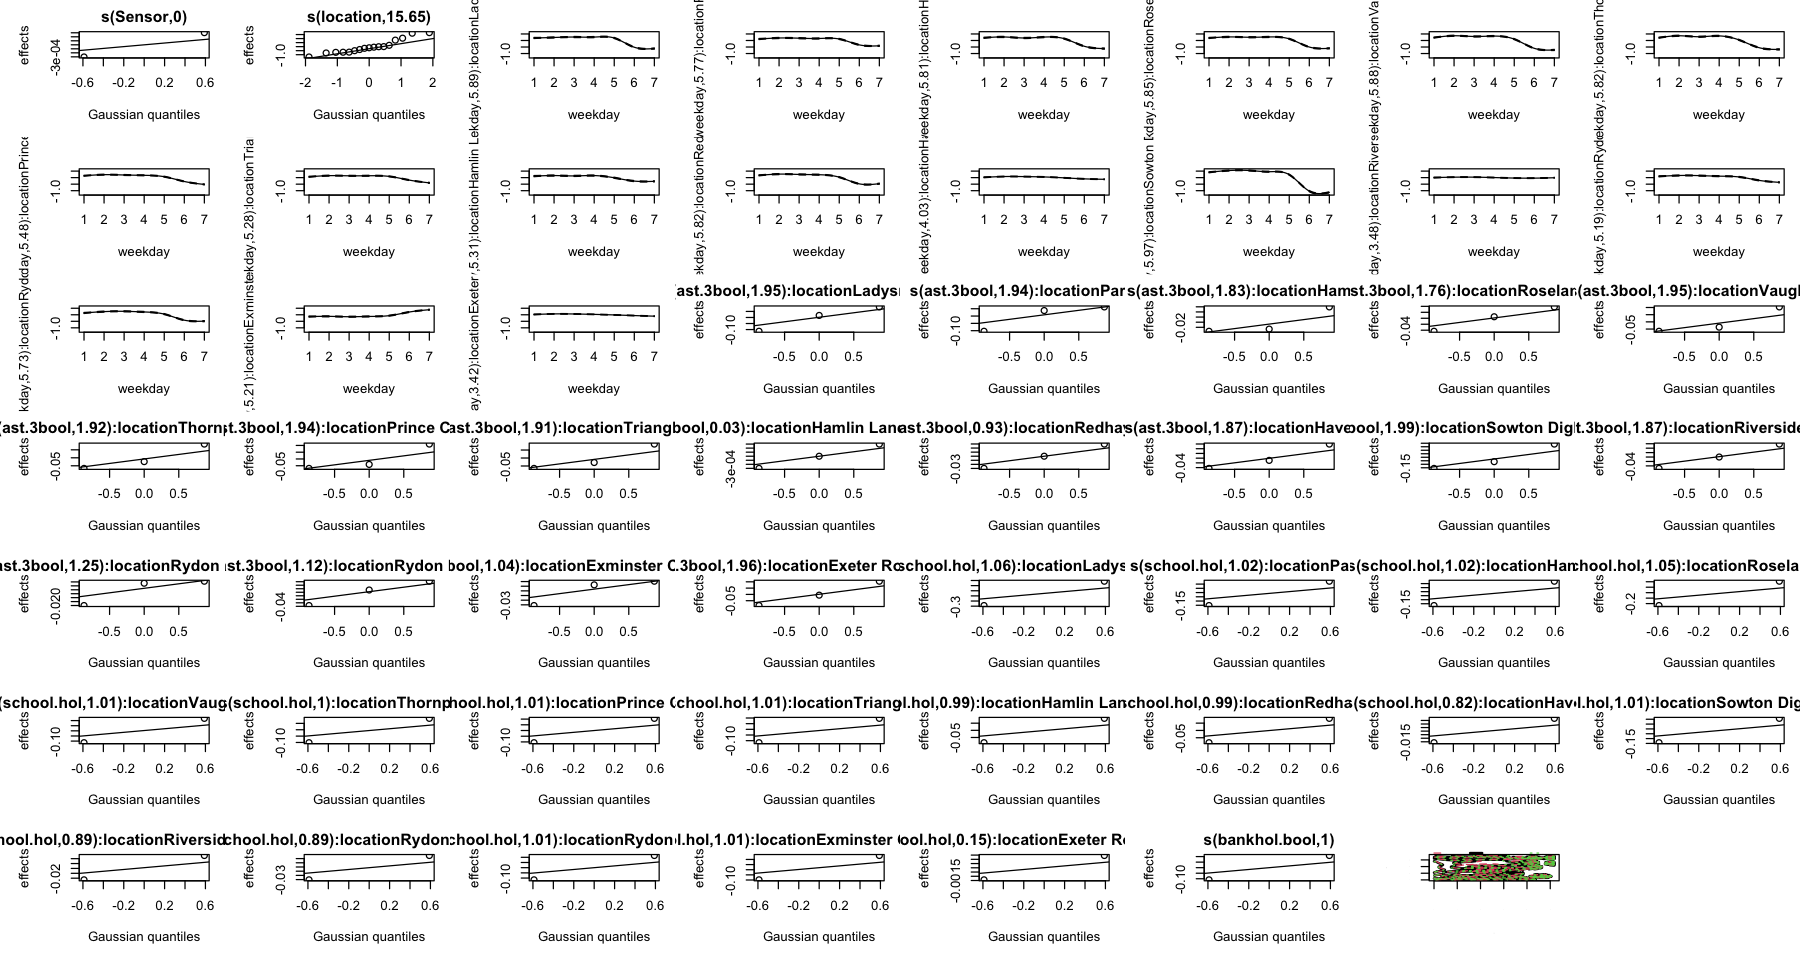

In [181]:
par(bg = "white")
plot(nb.m5, pages=1)



Method: REML   Optimizer: outer newton
full convergence after 16 iterations.
Gradient range [-0.002867467,0.001449153]
(score 77243.39 & scale 1).
Hessian positive definite, eigenvalue range [0.001198737,5561.033].
Model rank =  258 / 258 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                                                     k'    edf k-index p-value
s(location)                                      17.000 15.649      NA      NA
s(weekday):locationLadysmith Road                 6.000  5.891    0.99    0.46
s(weekday):locationPark Road                      6.000  5.773    0.99    0.42
s(weekday):locationHamlin Lane                    6.000  5.809    0.99    0.43
s(weekday):locationRoseland Crescent              6.000  5.852    0.99    0.34
s(weekday):locationVaughan Road                   6.000  5.875    0.99    0.45
s(weekday):locationThornpark Road                 6.000  5.823    0.99    0.

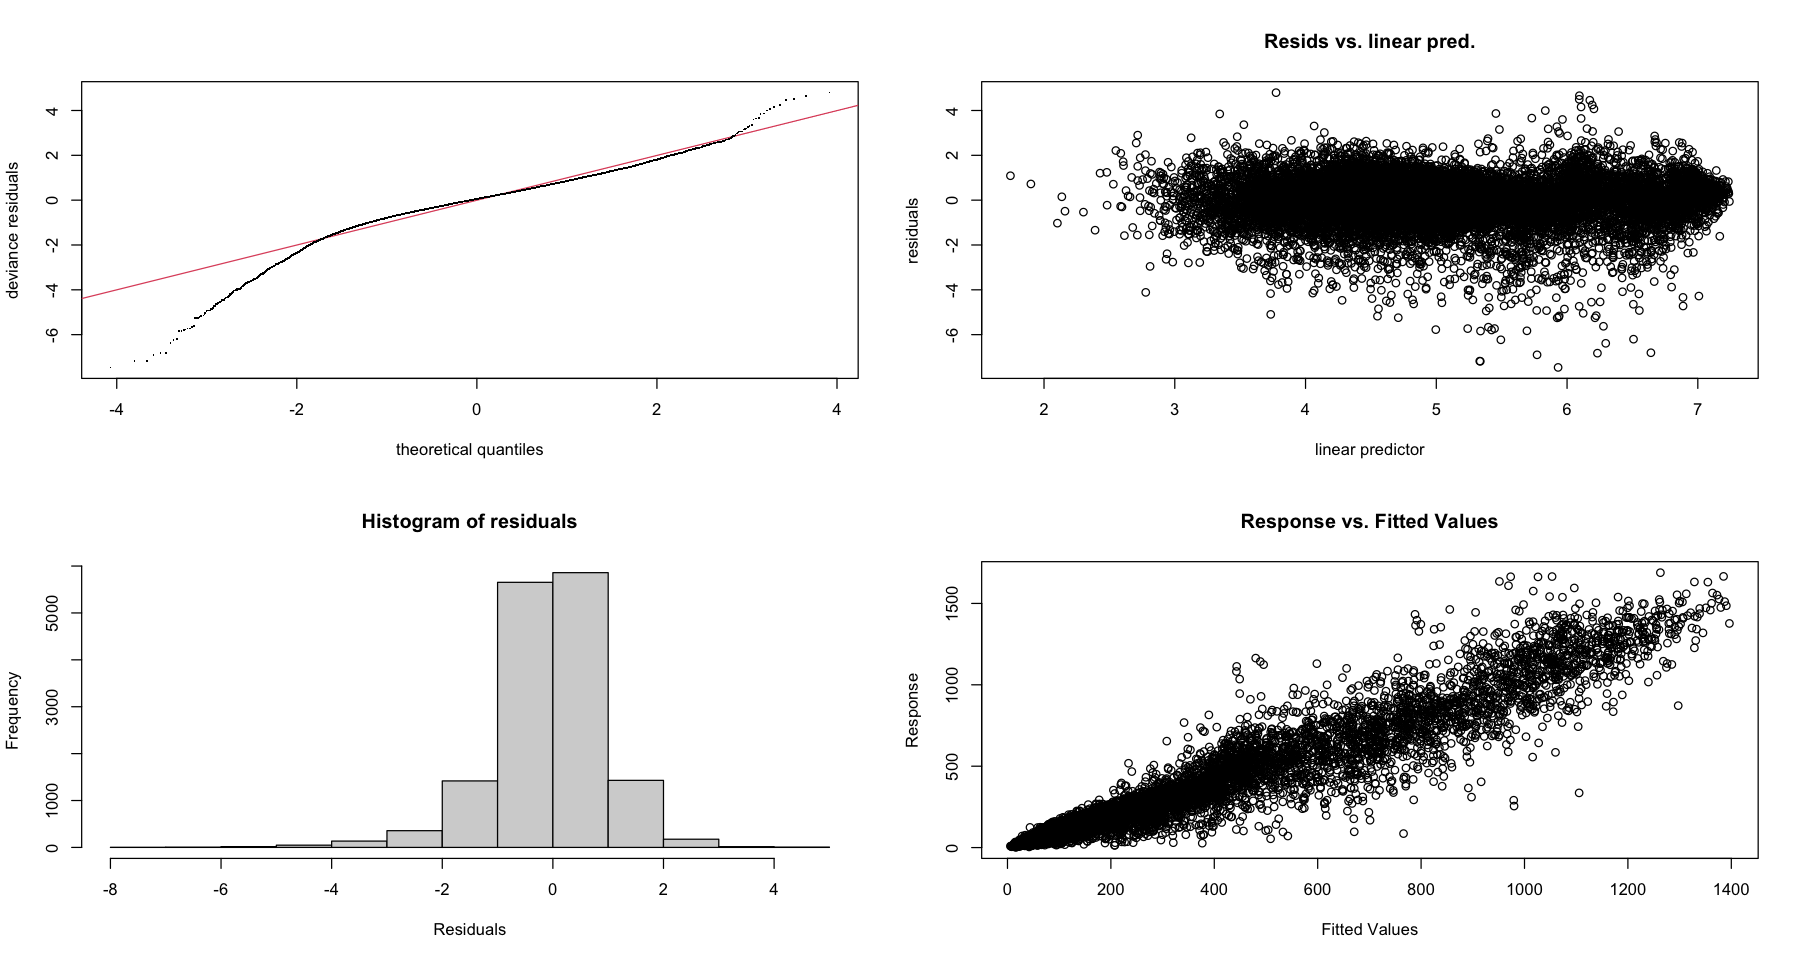

In [15]:
par(bg = "white")
gam.check(nb.m5)

In [188]:
write_csv(as.data.frame(nb.m5$residuals), file = "residuals.csv")

In [190]:
pred.df <- df %>% ungroup() %>% mutate(res = nb.m5$residuals)

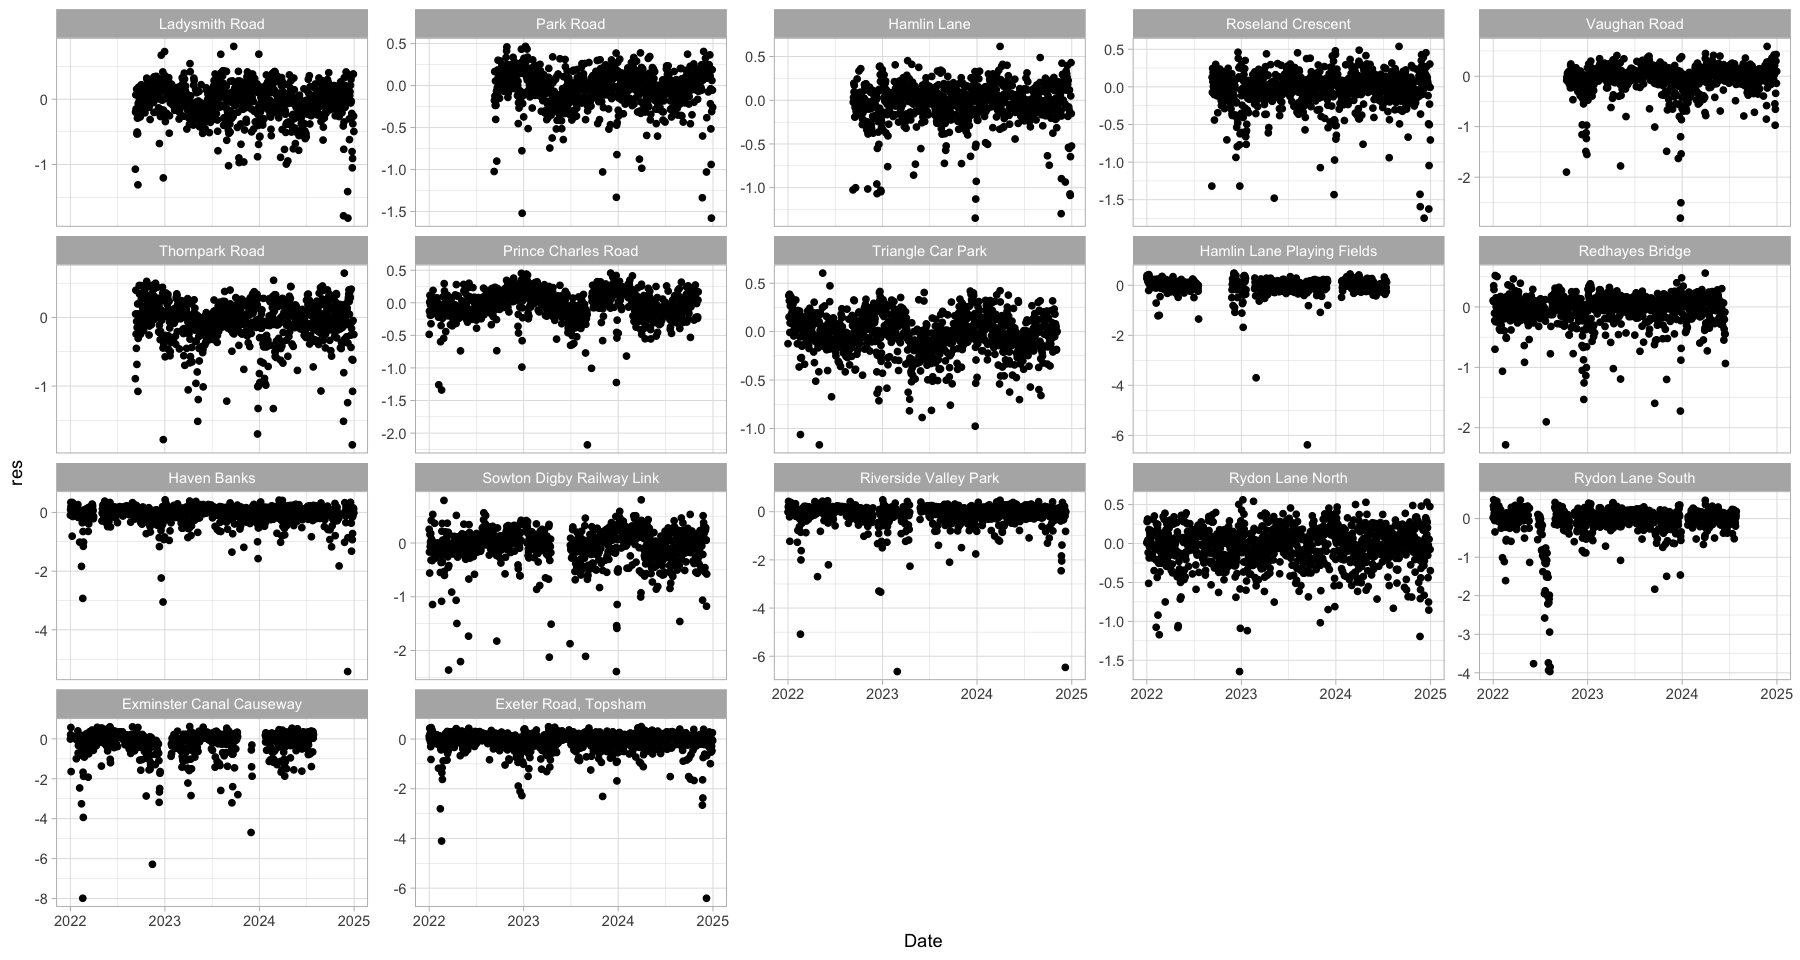

In [192]:
ggplot(data = pred.df, aes(x=Date, y=res)) + 
    geom_point() + 
    facet_wrap(~location, scales = "free_y") +
    theme_light()

## Define conditional prediction grid

In [54]:
pred.avg.weekday = datagrid(model = nb.m5, ast.3bool = 'After', weekday=seq(1,5), location=levels(df$location), rain=0, doy=seq(1,365))
# Define 'average' rainy day = 3 mm/day
pred.avg.weekday.rain = datagrid(model = nb.m5, ast.3bool = 'After', weekday=seq(1,5), location=levels(df$location), rain=3, doy=seq(1,365))

## Year Effect

In [17]:
avg_predictions(nb.m5, variables = 'year', type = 'response', conf_level=0.9, vcov=TRUE)

year estimate std.error statistic p.value s.value conf.low conf.high df 
1 0    251.8141 0.6981965 360.6636  0       Inf     250.6656 252.9625  Inf
2 1    251.8141 0.6981965 360.6636  0       Inf     250.6656 252.9625  Inf
3 2    251.8141 0.6981965 360.6636  0       Inf     250.6656 252.9625  Inf

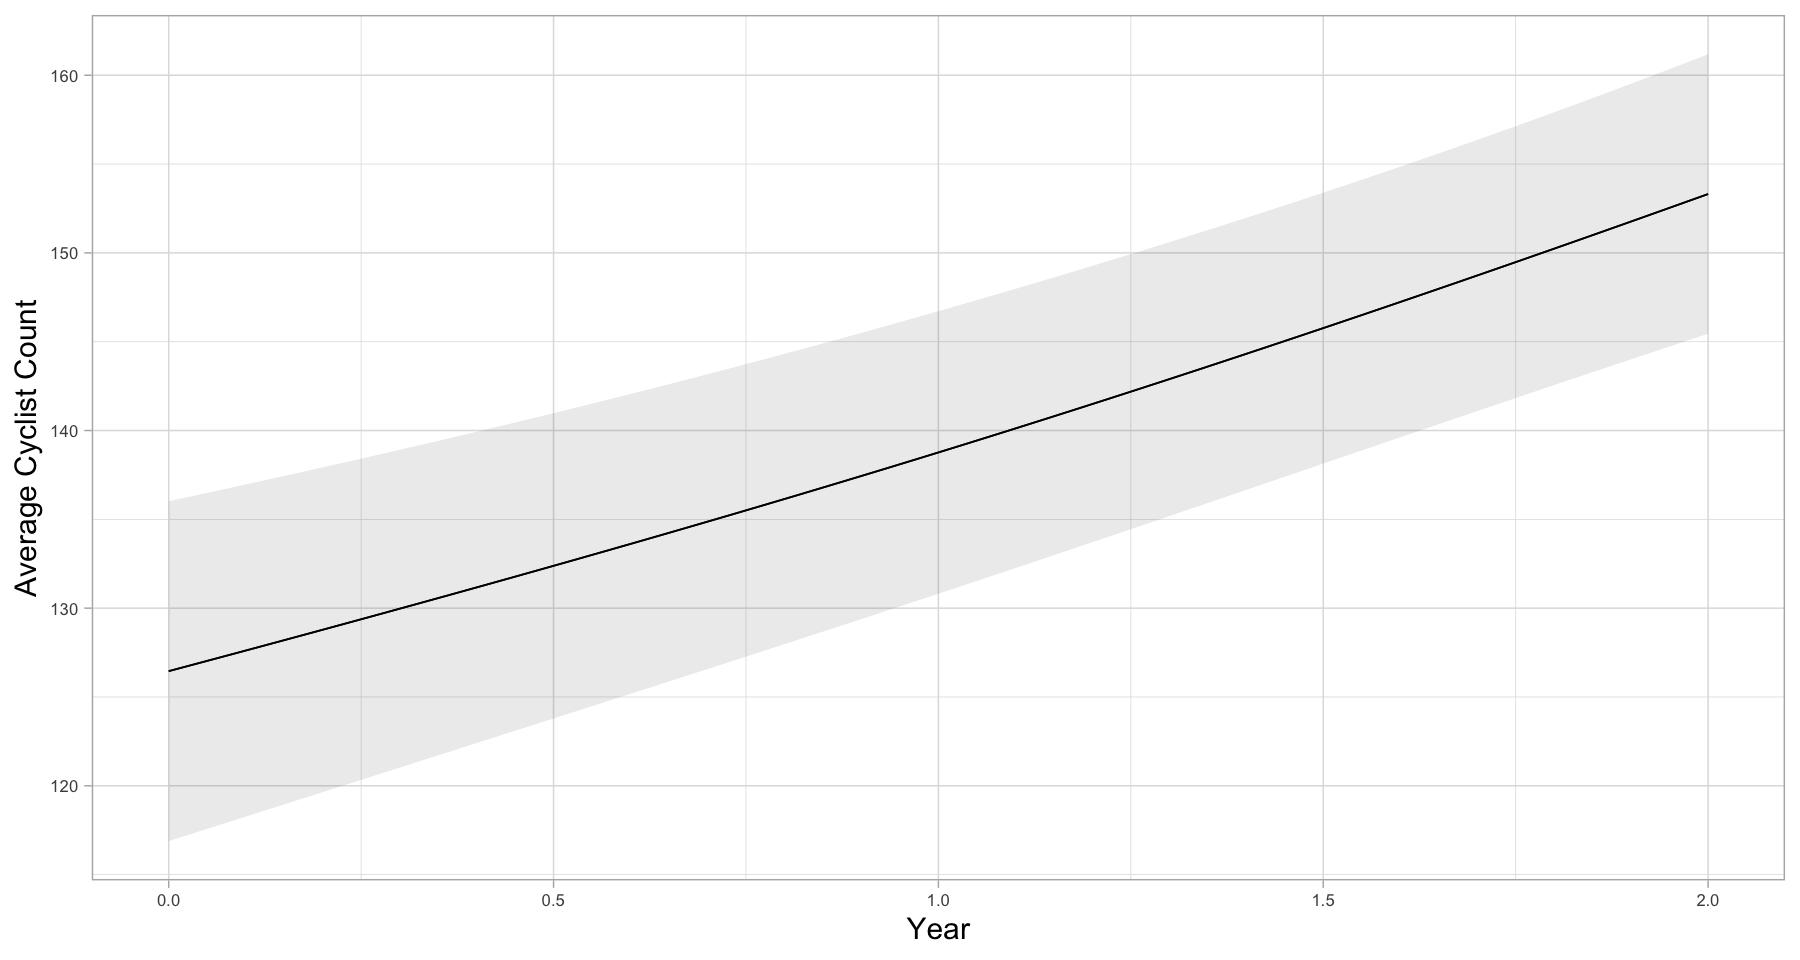

In [179]:
# Conditional (partial) effect
plot_predictions(nb.m5, condition = 'year', type = 'response', vcov = TRUE,
newdata = datagrid(school.hol = as.factor(0), bankhol.bool = as.factor(0), weekday=c(1,2,3,4,5))) + 
labs(x = "Year", y = "Average Cyclist Count") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10))

## Location Effect

In [18]:
# Marginal effect of location
avg_predictions(nb.m5, variables = 'location', type = 'response', conf_level=0.9, vcov=TRUE)


location                   estimate  std.error statistic p.value s.value
1  Ladysmith Road              86.45489 0.8311716 104.01568 0       Inf    
2  Park Road                  114.10445 1.0315431 110.61530 0       Inf    
3  Hamlin Lane                 84.33021 0.7971204 105.79357 0       Inf    
4  Roseland Crescent          146.22001 1.3311036 109.84871 0       Inf    
5  Vaughan Road               201.49631 1.8596546 108.35147 0       Inf    
6  Thornpark Road             105.45107 0.9992827 105.52677 0       Inf    
7  Prince Charles Road        170.66565 1.3628159 125.23016 0       Inf    
8  Triangle Car Park           84.53788 0.6934698 121.90565 0       Inf    
9  Hamlin Lane Playing Fields 140.42724 1.3605057 103.21694 0       Inf    
10 Redhayes Bridge            154.70048 1.7015984  90.91480 0       Inf    
11 Haven Banks                890.40546 6.4314561 138.44539 0       Inf    
12 Sowton Digby Railway Link   93.66848 0.8447363 110.88487 0       Inf    
13 Riverside Valley Park      811.35058 6.1234842 132.49819 0       Inf    
14 Rydon Lane North            43.20669 0.3791806 113.94752 0       Inf    
15 Rydon Lane South           168.65136 1.8160608  92.86658 0       Inf    
16 Exminster Canal Causeway   423.84577 4.4726752  94.76337 0       Inf    
17 Exeter Road, Topsham       354.83649 2.5563815 138.80420 0       Inf    
   conf.low  conf.high df 
1   85.08773  87.82204 Inf
2  112.40771 115.80119 Inf
3   83.01907  85.64136 Inf
4  144.03054 148.40948 Inf
5  198.43745 204.55517 Inf
6  103.80740 107.09475 Inf
7  168.42401 172.90728 Inf
8   83.39723  85.67854 Inf
9  138.18940 142.66507 Inf
10 151.90160 157.49936 Inf
11 879.82665 900.98426 Inf
12  92.27901  95.05795 Inf
13 801.27834 821.42281 Inf
14  42.58299  43.83038 Inf
15 165.66421 171.63852 Inf
16 416.48888 431.20267 Inf
17 350.63162 359.04136 Inf

In [56]:
# Conditional estimate for average weekday
loc_pred <- avg_predictions(nb.m5, by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, 
newdata = pred.avg.weekday)
loc_pred

location                   estimate  std.error statistic p.value      
1  Ladysmith Road             139.98748  3.156991 44.34206   0.000000e+00
2  Park Road                  167.50602  3.646663 45.93405   0.000000e+00
3  Hamlin Lane                114.67561  2.524767 45.42028   0.000000e+00
4  Roseland Crescent          213.31077  4.432596 48.12322   0.000000e+00
5  Vaughan Road               328.59332  6.996029 46.96854   0.000000e+00
6  Thornpark Road             141.54513  3.120592 45.35842   0.000000e+00
7  Prince Charles Road        205.33812  5.243844 39.15794   0.000000e+00
8  Triangle Car Park           99.72028  2.626165 37.97183  1.683622e-315
9  Hamlin Lane Playing Fields 179.29626  2.233754 80.26678   0.000000e+00
10 Redhayes Bridge            209.00639 11.464101 18.23138   2.908855e-74
11 Haven Banks                980.45184 19.995427 49.03380   0.000000e+00
12 Sowton Digby Railway Link  114.48809  2.806699 40.79101   0.000000e+00
13 Riverside Valley Park      840.34689 17.259323 48.68945   0.000000e+00
14 Rydon Lane North            54.93331  1.054643 52.08710   0.000000e+00
15 Rydon Lane South           231.82018 12.230206 18.95472   4.036694e-80
16 Exminster Canal Causeway   394.06260 17.861405 22.06224  7.288290e-108
17 Exeter Road, Topsham       359.73686  6.973837 51.58378   0.000000e+00
   s.value   conf.low  conf.high  df 
1        Inf 134.79469  145.18027 Inf
2        Inf 161.50779  173.50425 Inf
3        Inf 110.52274  118.82848 Inf
4        Inf 206.01980  220.60174 Inf
5        Inf 317.08587  340.10076 Inf
6        Inf 136.41221  146.67804 Inf
7        Inf 196.71277  213.96348 Inf
8  1045.6558  95.40062  104.03994 Inf
9        Inf 175.62206  182.97046 Inf
10  244.2822 190.14962  227.86316 Inf
11       Inf 947.56229 1013.34139 Inf
12       Inf 109.87148  119.10470 Inf
13       Inf 811.95783  868.73595 Inf
14       Inf  53.19858   56.66805 Inf
15  263.7411 211.70328  251.93708 Inf
16  355.9027 364.68320  423.44199 Inf
17       Inf 348.26592  371.20780 Inf

In [ ]:
# Conditional estimate for average weekday with average rain
loc_pred.rain <- avg_predictions(nb.m5, by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, 
newdata = pred.avg.weekday.rain)
loc_pred.rain

location                   estimate  std.error  statistic p.value      
1  Ladysmith Road             115.61191  2.6374948 43.83399   0.000000e+00
2  Park Road                  138.33874  3.0504162 45.35078   0.000000e+00
3  Hamlin Lane                 94.70752  2.1110926 44.86185   0.000000e+00
4  Roseland Crescent          176.16766  3.7095383 47.49045   0.000000e+00
5  Vaughan Road               271.37643  5.8511571 46.37996   0.000000e+00
6  Thornpark Road             116.89833  2.6093283 44.80016   0.000000e+00
7  Prince Charles Road        169.58326  4.3682161 38.82209   0.000000e+00
8  Triangle Car Park           82.35631  2.1875895 37.64706  3.654972e-310
9  Hamlin Lane Playing Fields 148.07598  1.8935131 78.20172   0.000000e+00
10 Redhayes Bridge            172.61278  9.4797288 18.20862   4.409170e-74
11 Haven Banks                809.72894 16.7100874 48.45749   0.000000e+00
12 Sowton Digby Railway Link   94.55265  2.3391412 40.42195   0.000000e+00
13 Riverside Valley Park      694.02000 14.4278020 48.10296   0.000000e+00
14 Rydon Lane North            45.36795  0.8820649 51.43380   0.000000e+00
15 Rydon Lane South           191.45408 10.1156459 18.92653   6.895750e-80
16 Exminster Canal Causeway   325.44575 14.7809238 22.01796  1.938040e-107
17 Exeter Road, Topsham       297.09705  5.8386093 50.88490   0.000000e+00
   s.value   conf.low  conf.high df 
1        Inf 111.27362 119.95021 Inf
2        Inf 133.32125 143.35623 Inf
3        Inf  91.23508  98.17995 Inf
4        Inf 170.06601 182.26930 Inf
5        Inf 261.75213 281.00072 Inf
6        Inf 112.60637 121.19029 Inf
7        Inf 162.39819 176.76834 Inf
8  1027.9278  78.75805  85.95457 Inf
9        Inf 144.96143 151.19054 Inf
10  243.6822 157.02002 188.20555 Inf
11       Inf 782.24329 837.21458 Inf
12       Inf  90.70510  98.40019 Inf
13       Inf 670.28838 717.75162 Inf
14       Inf  43.91709  46.81882 Inf
15  262.9685 174.81532 208.09284 Inf
16  354.4917 301.13330 349.75821 Inf
17       Inf 287.49339 306.70070 Inf

In [138]:
loc_pred.all <- loc_pred %>% mutate(estimate_rain = loc_pred.rain$estimate) %>% 
mutate(location=case_match(location, "Haven Banks" ~ "Haven Banks (NCN 34)",
"Triangle Car Park" ~ "Triangle Car Par (E3)",
"Hamlin Lane Playing Fields" ~ "Hamlin Lane Playing Fields (E12)",
"Riverside Valley Park" ~ "Riverside Valley Park (NCN 34)",
"Exminster Canal Causeway" ~ "Exminster Canal Causeway (NCN 2)",
"Exeter Road, Topsham" ~ "Exeter Road, Topsham (NCN 2)",
"Redhayes Bridge" ~ "Redhayes Bridge (E3)",
"Vaughan Road" ~ "Vaughan Road (E3)",
"Prince Charles Road" ~ "Prince Charles Road (E4)",
"Roseland Crescent" ~ "Roseland Crescent (E3)",
"Thornpark Road" ~ "Thornpark Rise",
.default = location)) %>%
arrange(estimate) %>% 
mutate(location=factor(location, levels=location))
qs_save(loc_pred.all, "Rdata/location.pred.2022-2024.qs2")

In [139]:
loc_pred.all

location                         estimate  std.error statistic p.value      
1  Rydon Lane North                  54.93331  1.054643 52.08710   0.000000e+00
2  Triangle Car Par (E3)             99.72028  2.626165 37.97183  1.683622e-315
3  Sowton Digby Railway Link        114.48809  2.806699 40.79101   0.000000e+00
4  Hamlin Lane                      114.67561  2.524767 45.42028   0.000000e+00
5  Ladysmith Road                   139.98748  3.156991 44.34206   0.000000e+00
6  Thornpark Rise                   141.54513  3.120592 45.35842   0.000000e+00
7  Park Road                        167.50602  3.646663 45.93405   0.000000e+00
8  Hamlin Lane Playing Fields (E12) 179.29626  2.233754 80.26678   0.000000e+00
9  Prince Charles Road (E4)         205.33812  5.243844 39.15794   0.000000e+00
10 Redhayes Bridge (E3)             209.00639 11.464101 18.23138   2.908855e-74
11 Roseland Crescent (E3)           213.31077  4.432596 48.12322   0.000000e+00
12 Rydon Lane South                 231.82018 12.230206 18.95472   4.036694e-80
13 Vaughan Road (E3)                328.59332  6.996029 46.96854   0.000000e+00
14 Exeter Road, Topsham (NCN 2)     359.73686  6.973837 51.58378   0.000000e+00
15 Exminster Canal Causeway (NCN 2) 394.06260 17.861405 22.06224  7.288290e-108
16 Riverside Valley Park (NCN 34)   840.34689 17.259323 48.68945   0.000000e+00
17 Haven Banks (NCN 34)             980.45184 19.995427 49.03380   0.000000e+00
   s.value   conf.low  conf.high  df  estimate_rain
1        Inf  53.19858   56.66805 Inf  45.36795    
2  1045.6558  95.40062  104.03994 Inf  82.35631    
3        Inf 109.87148  119.10470 Inf  94.55265    
4        Inf 110.52274  118.82848 Inf  94.70752    
5        Inf 134.79469  145.18027 Inf 115.61191    
6        Inf 136.41221  146.67804 Inf 116.89833    
7        Inf 161.50779  173.50425 Inf 138.33874    
8        Inf 175.62206  182.97046 Inf 148.07598    
9        Inf 196.71277  213.96348 Inf 169.58326    
10  244.2822 190.14962  227.86316 Inf 172.61278    
11       Inf 206.01980  220.60174 Inf 176.16766    
12  263.7411 211.70328  251.93708 Inf 191.45408    
13       Inf 317.08587  340.10076 Inf 271.37643    
14       Inf 348.26592  371.20780 Inf 297.09705    
15  355.9027 364.68320  423.44199 Inf 325.44575    
16       Inf 811.95783  868.73595 Inf 694.02000    
17       Inf 947.56229 1013.34139 Inf 809.72894

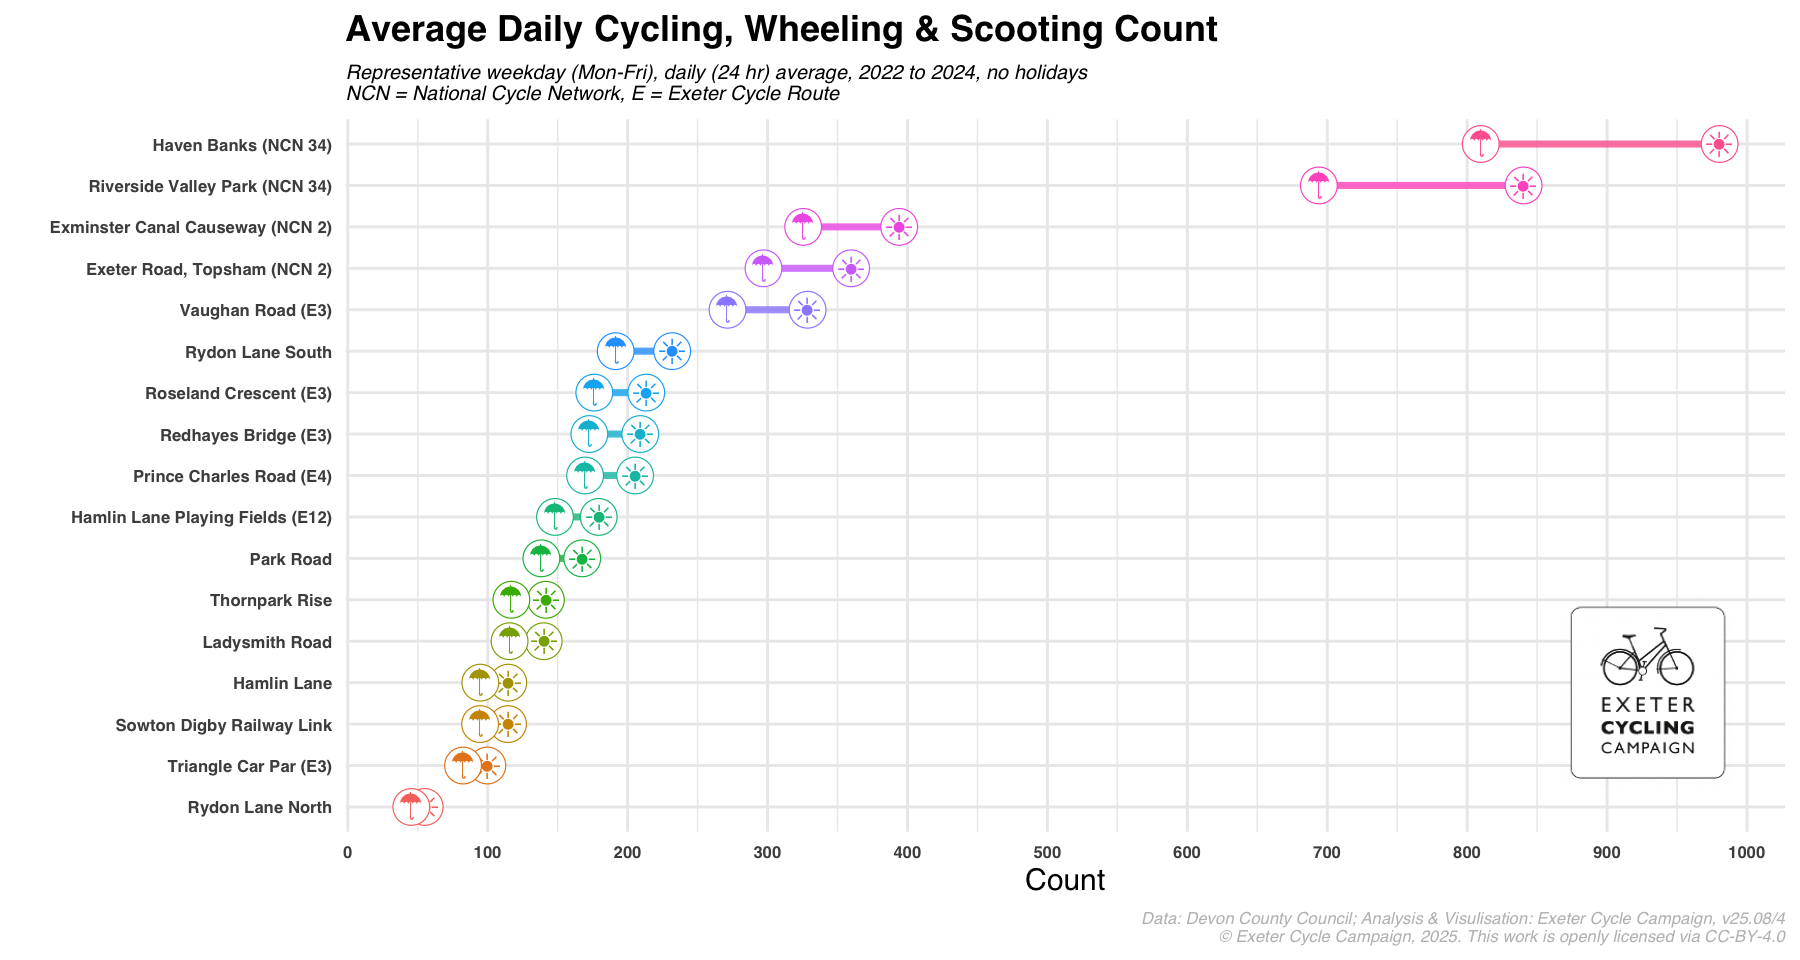

In [159]:
# Plotting
VERSION <- format(today(), "v%y.%m/4")
p1 <- ggplot(data=loc_pred.all, aes(x=estimate, y=location, colour=location)) + 
geom_linerange(aes(xmin=estimate_rain, xmax=estimate), size=2, alpha=0.8) + 
geom_point(size=10, shape=21, fill="White") + geom_text(size=10, label="\u2600", family = "Apple Symbols") +
geom_point(aes(x=estimate_rain), size=10, shape=21, fill = "White") + geom_text(aes(x=estimate_rain), size=10, label="\u2602", family = "Apple Symbols") +
scale_x_continuous(breaks=seq(0, 1200, 100))+
labs(title="Average Daily Cycling, Wheeling & Scooting Count", 
subtitle="Representative weekday (Mon-Fri), daily (24 hr) average, 2022 to 2024, no holidays\nNCN = National Cycle Network, E = Exeter Cycle Route",
y = "", x = "Count", 
caption = paste0("Data: Devon County Council; Analysis & Visulisation: Exeter Cycle Campaign, ", VERSION, "\n © Exeter Cycle Campaign, 2025. This work is openly licensed via CC-BY-4.0")) + 
theme_minimal(base_size = 18) +
theme(axis.text = element_text(size = 10, face = "bold"),
    plot.title = element_text(face = "bold"),
    plot.subtitle = element_text(size = 12, face = "italic"),
        plot.caption = element_text(size = 10, face = "italic", colour = "grey"),
        legend.position="none",
        text=element_text(family="Helvetica"))
ggdraw(p1) + draw_image("Exeter-Cycling-Campain-Logo.png", x = 0.98, y = .18, hjust = 1, vjust = 0, width = 0.13, height = 0.2)
# Save figure
ggsave2(filename = "plots/location_average.jpg", width = 16, height = 8, dpi = 300)

[1] "v25.08/3"

## School Holiday Effect

Conditional estimate for average weekday:

In [32]:
schhol_pred <- avg_comparisons(nb.m5, variables='school.hol', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, comparison = 'ratio',
newdata = pred.avg.weekday)

In [33]:
schhol_pred

term       contrast          location                   estimate  std.error 
1  school.hol mean(0) / mean(1) Ladysmith Road             1.6056853 0.03811932
2  school.hol mean(0) / mean(1) Park Road                  1.3325585 0.02998231
3  school.hol mean(0) / mean(1) Hamlin Lane                1.3528222 0.03165703
4  school.hol mean(0) / mean(1) Roseland Crescent          1.5609540 0.03531281
5  school.hol mean(0) / mean(1) Vaughan Road               1.2676158 0.02718572
6  school.hol mean(0) / mean(1) Thornpark Road             1.2106564 0.02710345
7  school.hol mean(0) / mean(1) Prince Charles Road        1.2375764 0.02356135
8  school.hol mean(0) / mean(1) Triangle Car Park          1.2393191 0.02488744
9  school.hol mean(0) / mean(1) Hamlin Lane Playing Fields 1.1854865 0.03145424
10 school.hol mean(0) / mean(1) Redhayes Bridge            1.1810531 0.02480020
11 school.hol mean(0) / mean(1) Haven Banks                1.0347759 0.01689061
12 school.hol mean(0) / mean(1) Sowton Digby Railway Link  1.2857056 0.02687774
13 school.hol mean(0) / mean(1) Riverside Valley Park      0.9514126 0.01640885
14 school.hol mean(0) / mean(1) Rydon Lane North           1.0596157 0.02151420
15 school.hol mean(0) / mean(1) Rydon Lane South           1.2641159 0.02774808
16 school.hol mean(0) / mean(1) Exminster Canal Causeway   0.7892105 0.01687907
17 school.hol mean(0) / mean(1) Exeter Road, Topsham       0.9971339 0.00688009
   statistic p.value      s.value  conf.low  conf.high predicted_lo
1   42.12261  0.00000e+00      Inf 1.5429846 1.6683860  50.10488   
2   44.44482  0.00000e+00      Inf 1.2832420 1.3818750  72.09415   
3   42.73370  0.00000e+00      Inf 1.3007510 1.4048934  50.10121   
4   44.20362  0.00000e+00      Inf 1.5028696 1.6190384  78.94909   
5   46.62801  0.00000e+00      Inf 1.2228993 1.3123323 147.11511   
6   44.66798  0.00000e+00      Inf 1.1660752 1.2552376  66.75813   
7   52.52570  0.00000e+00      Inf 1.1988214 1.2763314  96.71692   
8   49.79697  0.00000e+00      Inf 1.1983829 1.2802553  45.38012   
9   37.68925 7.45131e-311 1030.222 1.1337489 1.2372241  90.41113   
10  47.62274  0.00000e+00      Inf 1.1402605 1.2218458 103.57473   
11  61.26337  0.00000e+00      Inf 1.0069933 1.0625585 552.51870   
12  47.83533  0.00000e+00      Inf 1.2414956 1.3299155  51.34470   
13  57.98168  0.00000e+00      Inf 0.9244224 0.9784027 523.12480   
14  49.25192  0.00000e+00      Inf 1.0242280 1.0950034  30.32184   
15  45.55688  0.00000e+00      Inf 1.2184743 1.3097574 104.13391   
16  46.75675  0.00000e+00      Inf 0.7614469 0.8169741 292.30775   
17 144.93037  0.00000e+00      Inf 0.9858172 1.0084506 212.50925   
   predicted_hi predicted
1   80.45267     80.45267
2   96.06967     96.06967
3   67.77803     67.77803
4  123.23590    123.23590
5  186.48544    186.48544
6   80.82116     80.82116
7  119.69458    119.69458
8   56.24045     56.24045
9  107.18117    107.18117
10 122.32726    122.32726
11 571.73304    571.73304
12  66.01416     66.01416
13 497.70750    497.70750
14  32.12950     32.12950
15 131.63733    131.63733
16 230.69235    230.69235
17 211.90017    211.90017

In [36]:
avg_comparisons(nb.m5, variables='school.hol', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, comparison = 'difference',
newdata = pred.avg.weekday)

term       contrast location                   estimate    std.error
1  school.hol 0 - 1    Ladysmith Road               52.805092  2.716583
2  school.hol 0 - 1    Park Road                    41.803458  3.240274
3  school.hol 0 - 1    Hamlin Lane                  29.907920  2.281052
4  school.hol 0 - 1    Roseland Crescent            76.656667  3.925123
5  school.hol 0 - 1    Vaughan Road                 69.371784  6.211843
6  school.hol 0 - 1    Thornpark Road               24.629105  2.841112
7  school.hol 0 - 1    Prince Charles Road          39.418571  3.587806
8  school.hol 0 - 1    Triangle Car Park            19.256518  1.826610
9  school.hol 0 - 1    Hamlin Lane Playing Fields   28.053488  4.154486
10 school.hol 0 - 1    Redhayes Bridge              32.040272  4.249910
11 school.hol 0 - 1    Haven Banks                  32.950228 15.665843
12 school.hol 0 - 1    Sowton Digby Railway Link    25.441193  2.111799
13 school.hol 0 - 1    Riverside Valley Park       -42.915464 15.032453
14 school.hol 0 - 1    Rydon Lane North              3.090639  1.071792
15 school.hol 0 - 1    Rydon Lane South             48.434948  4.928056
16 school.hol 0 - 1    Exminster Canal Causeway   -105.249811 11.265669
17 school.hol 0 - 1    Exeter Road, Topsham         -1.034005  2.487085
   statistic p.value      s.value     conf.low    conf.high 
1  19.438053 3.678629e-84 277.1627919   48.336710  57.273474
2  12.901212 4.430719e-38 124.0857268   36.473683  47.133234
3  13.111458 2.831031e-39 128.0538684   26.155923  33.659917
4  19.529749 6.134053e-85 279.7470474   70.200414  83.112920
5  11.167665 5.870373e-29  93.7824626   59.154211  79.589356
6   8.668826 4.366000e-18  57.6683936   19.955892  29.302319
7  10.986819 4.422368e-28  90.8691675   33.517156  45.319986
8  10.542214 5.518431e-26  83.9058723   16.252011  22.261025
9   6.752577 1.452418e-11  36.0027522   21.219966  34.887009
10  7.539048 4.734146e-14  44.2638891   25.049793  39.030751
11  2.103317 3.543810e-02   4.8185550    7.182210  58.718246
12 12.047168 2.007296e-33 108.6183737   21.967593  28.914793
13 -2.854854 4.305658e-03   7.8595505  -67.641650 -18.189278
14  2.883618 3.931355e-03   7.9907575    1.327698   4.853580
15  9.828409 8.494987e-23  73.3177344   40.329018  56.540878
16 -9.342527 9.406195e-21  66.5268788 -123.780187 -86.719436
17 -0.415750 6.775929e-01   0.5615093   -5.124895   3.056885

In [37]:
p2 <- plot_comparisons(nb.m5, variables='school.hol', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, newdata = pred.avg.weekday)

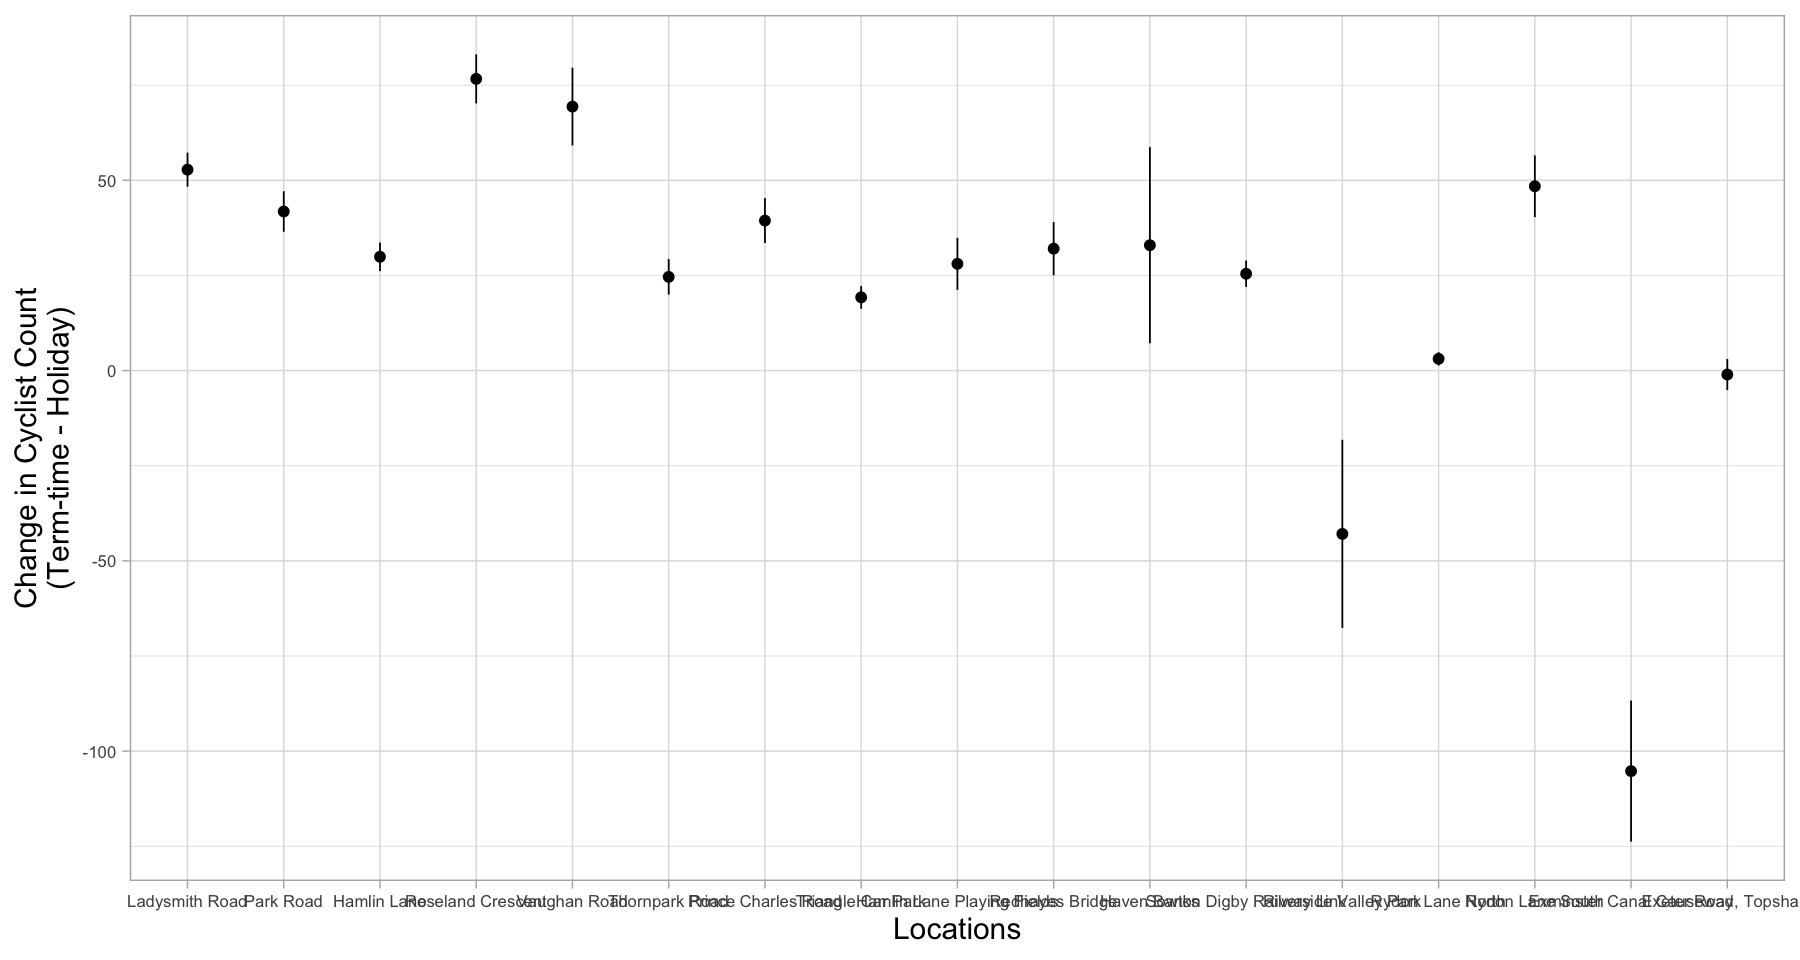

In [38]:
# Plot styling
p2 + labs(x = "Locations", y = "Change in Cyclist Count\n(Term-time - Holiday)") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10))

## Bank Holiday Effect

In [40]:
avg_comparisons(nb.m5, variables='bankhol.bool', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, 
comparison = function(hi, lo) mean(lo)-mean(hi),
newdata = pred.avg.weekday)

term         contrast location                   estimate   std.error 
1  bankhol.bool 0, 1     Ladysmith Road              -27.56918  1.6566889
2  bankhol.bool 0, 1     Park Road                   -32.98869  1.9724271
3  bankhol.bool 0, 1     Hamlin Lane                 -22.58425  1.3522717
4  bankhol.bool 0, 1     Roseland Crescent           -42.00950  2.4970841
5  bankhol.bool 0, 1     Vaughan Road                -64.71328  3.8564907
6  bankhol.bool 0, 1     Thornpark Road              -27.87595  1.6700799
7  bankhol.bool 0, 1     Prince Charles Road         -40.43936  2.4742747
8  bankhol.bool 0, 1     Triangle Car Park           -19.63895  1.2090137
9  bankhol.bool 0, 1     Hamlin Lane Playing Fields  -35.31067  2.0143569
10 bankhol.bool 0, 1     Redhayes Bridge             -41.16179  3.2187053
11 bankhol.bool 0, 1     Haven Banks                -193.09052 11.4735868
12 bankhol.bool 0, 1     Sowton Digby Railway Link   -22.54732  1.3729059
13 bankhol.bool 0, 1     Riverside Valley Park      -165.49820  9.8309149
14 bankhol.bool 0, 1     Rydon Lane North            -10.81859  0.6384526
15 bankhol.bool 0, 1     Rydon Lane South            -45.65475  3.5107627
16 bankhol.bool 0, 1     Exminster Canal Causeway    -77.60682  5.5841997
17 bankhol.bool 0, 1     Exeter Road, Topsham        -70.84670  4.2167007
   statistic p.value      s.value  conf.low   conf.high  
1  -16.64113 3.509072e-62 204.1485  -30.29419  -24.844172
2  -16.72492 8.628635e-63 206.1723  -36.23305  -29.744339
3  -16.70097 1.289442e-62 205.5928  -24.80854  -20.359965
4  -16.82342 1.643874e-63 208.5644  -46.11683  -37.902158
5  -16.78035 3.398007e-63 207.5168  -71.05664  -58.369918
6  -16.69138 1.514176e-62 205.3610  -30.62298  -25.128909
7  -16.34393 4.805677e-60 197.0509  -44.50918  -36.369541
8  -16.24377 2.472325e-59 194.6879  -21.62760  -17.650296
9  -17.52950 8.531731e-69 226.1202  -38.62399  -31.997345
10 -12.78831 1.905813e-37 121.9809  -46.45609  -35.867491
11 -16.82913 1.492706e-63 208.7035 -211.96289 -174.218152
12 -16.42307 1.307898e-60 198.9284  -24.80555  -20.289094
13 -16.83447 1.364131e-63 208.8335 -181.66862 -149.327789
14 -16.94501 2.094980e-64 211.5365  -11.86875   -9.768425
15 -13.00422 1.157678e-38 126.0220  -51.42944  -39.880054
16 -13.89757 6.552563e-44 143.4528  -86.79201  -68.421632
17 -16.80145 2.381351e-63 208.0297  -77.78256  -63.910846

In [41]:
avg_comparisons(nb.m5, variables='bankhol.bool', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, 
comparison = function(hi, lo) mean(lo)/mean(hi),
newdata = pred.avg.weekday)

term         contrast location                   estimate  std.error 
1  bankhol.bool 0, 1     Ladysmith Road             0.8030597 0.01099203
2  bankhol.bool 0, 1     Park Road                  0.8030597 0.01099203
3  bankhol.bool 0, 1     Hamlin Lane                0.8030597 0.01099203
4  bankhol.bool 0, 1     Roseland Crescent          0.8030597 0.01099203
5  bankhol.bool 0, 1     Vaughan Road               0.8030597 0.01099203
6  bankhol.bool 0, 1     Thornpark Road             0.8030597 0.01099203
7  bankhol.bool 0, 1     Prince Charles Road        0.8030597 0.01099203
8  bankhol.bool 0, 1     Triangle Car Park          0.8030597 0.01099203
9  bankhol.bool 0, 1     Hamlin Lane Playing Fields 0.8030597 0.01099203
10 bankhol.bool 0, 1     Redhayes Bridge            0.8030597 0.01099203
11 bankhol.bool 0, 1     Haven Banks                0.8030597 0.01099203
12 bankhol.bool 0, 1     Sowton Digby Railway Link  0.8030597 0.01099203
13 bankhol.bool 0, 1     Riverside Valley Park      0.8030597 0.01099203
14 bankhol.bool 0, 1     Rydon Lane North           0.8030597 0.01099204
15 bankhol.bool 0, 1     Rydon Lane South           0.8030597 0.01099203
16 bankhol.bool 0, 1     Exminster Canal Causeway   0.8030597 0.01099203
17 bankhol.bool 0, 1     Exeter Road, Topsham       0.8030597 0.01099203
   statistic p.value s.value conf.low  conf.high
1  73.05836  0       Inf     0.7849794 0.8211399
2  73.05833  0       Inf     0.7849794 0.8211399
3  73.05836  0       Inf     0.7849794 0.8211399
4  73.05836  0       Inf     0.7849794 0.8211399
5  73.05836  0       Inf     0.7849794 0.8211399
6  73.05834  0       Inf     0.7849794 0.8211399
7  73.05834  0       Inf     0.7849794 0.8211399
8  73.05836  0       Inf     0.7849794 0.8211399
9  73.05839  0       Inf     0.7849794 0.8211399
10 73.05838  0       Inf     0.7849794 0.8211399
11 73.05836  0       Inf     0.7849794 0.8211399
12 73.05838  0       Inf     0.7849794 0.8211399
13 73.05839  0       Inf     0.7849794 0.8211399
14 73.05831  0       Inf     0.7849794 0.8211399
15 73.05834  0       Inf     0.7849794 0.8211399
16 73.05837  0       Inf     0.7849794 0.8211399
17 73.05839  0       Inf     0.7849794 0.8211399

In [42]:
p3 <- plot_comparisons(nb.m5, variables='bankhol.bool', by = 'location', type = 'response', conf_level=0.9, vcov=TRUE, 
comparison = function(hi, lo) mean(lo)-mean(hi),
newdata = pred.avg.weekday)

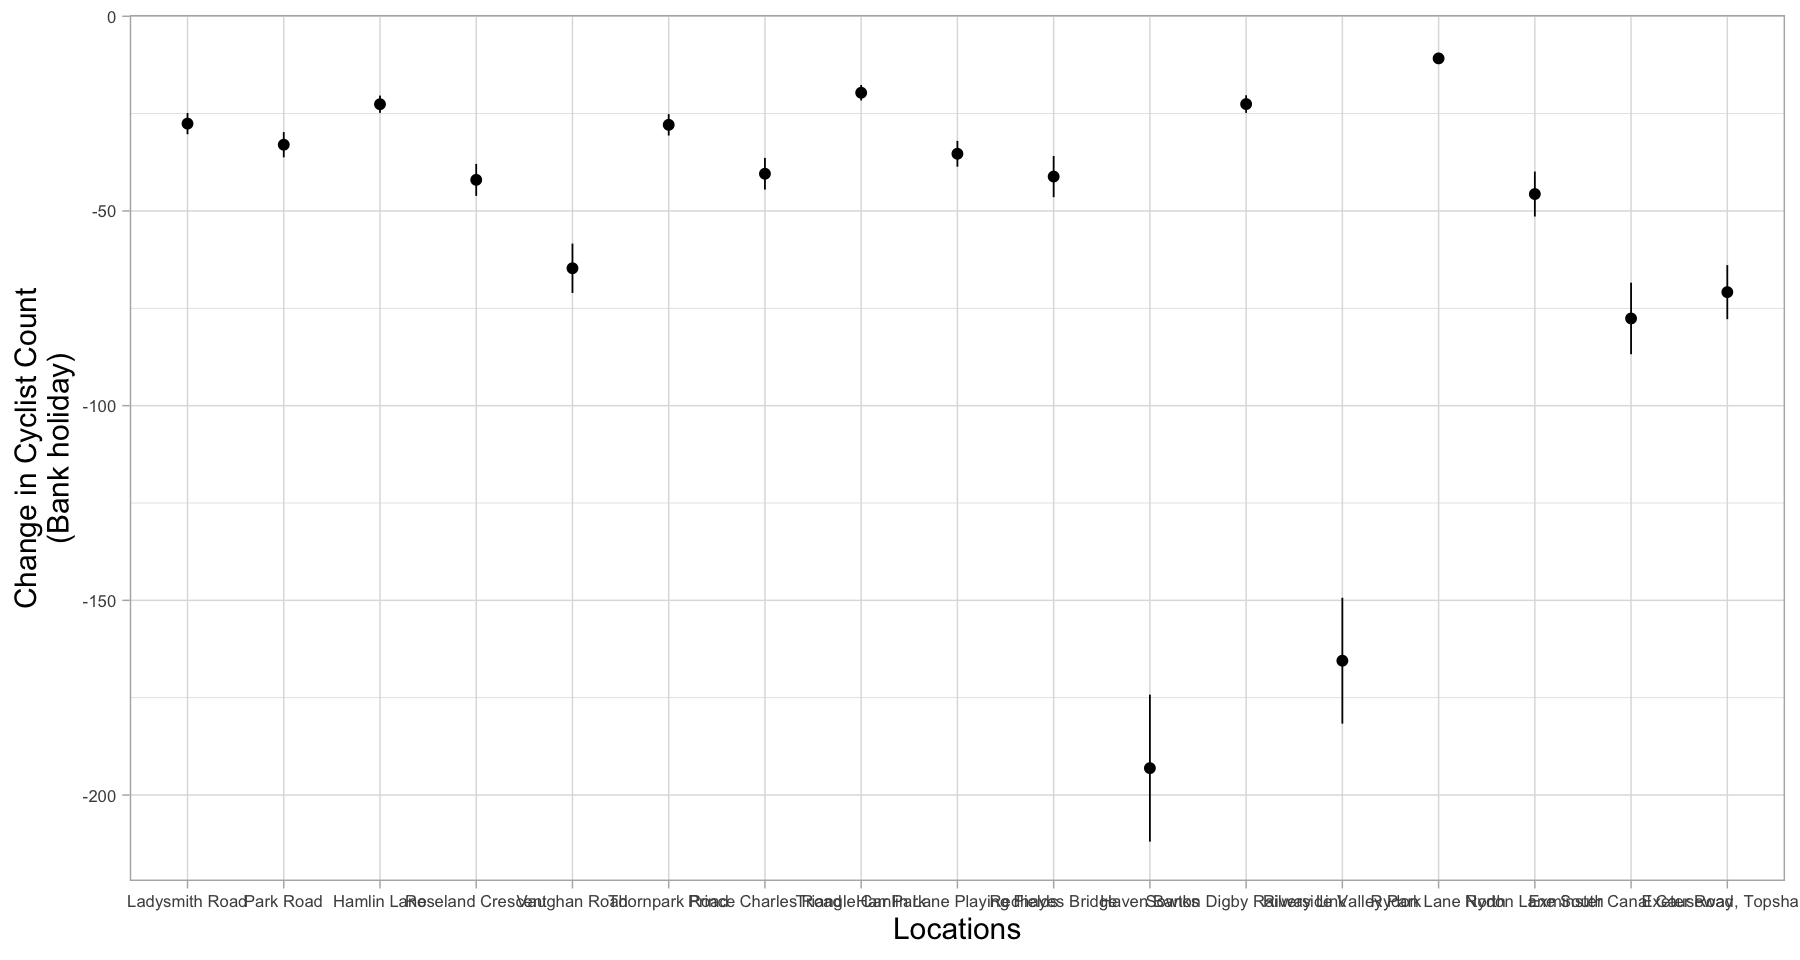

In [43]:
# Plot styling
p3 + labs(x = "Locations", y = "Change in Cyclist Count\n(Bank holiday)") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10))

## AST Effect

In [44]:
avg_comparisons(nb.m5, variables='ast.3bool', type = 'response', conf_level=0.9, vcov=TRUE, comparison = 'ratio')

term      contrast                    estimate  std.error   statistic p.value
1 ast.3bool mean(After) / mean(Before)  0.9309079 0.008726221 106.6794  0      
2 ast.3bool mean(During) / mean(Before) 0.9490877 0.005623065 168.7848  0      
  s.value conf.low  conf.high predicted_lo predicted_hi predicted
1 Inf     0.9165545 0.9452612 121.6517     130.5054     121.6517 
2 Inf     0.9398386 0.9583368 121.6517     106.7205     121.6517

In [45]:
avg_comparisons(nb.m5, variables='ast.3bool', type = 'response', conf_level=0.9, vcov=TRUE, comparison = 'difference')

term      contrast        estimate  std.error statistic p.value      s.value 
1 ast.3bool After - Before  -17.86629 2.286368  -7.814268 5.528355e-15 47.36207
2 ast.3bool During - Before -13.16522 1.487187  -8.852433 8.563200e-19 60.01848
  conf.low  conf.high
1 -21.62703 -14.10555
2 -15.61143 -10.71902

In [46]:
avg_comparisons(nb.m5, variables = 'ast.3bool', by='location', type = "response", conf_level=0.9, vcov=TRUE, comparison = 'ratio') %>% 
inferences(method = "simulation")

term      contrast                    location                   estimate 
1  ast.3bool mean(After) / mean(Before)  Ladysmith Road             1.0727797
2  ast.3bool mean(After) / mean(Before)  Park Road                  1.1808311
3  ast.3bool mean(After) / mean(Before)  Hamlin Lane                1.0084933
4  ast.3bool mean(After) / mean(Before)  Roseland Crescent          1.0498014
5  ast.3bool mean(After) / mean(Before)  Vaughan Road               1.1843604
6  ast.3bool mean(After) / mean(Before)  Thornpark Road             0.8959878
7  ast.3bool mean(After) / mean(Before)  Prince Charles Road        0.8354929
8  ast.3bool mean(After) / mean(Before)  Triangle Car Park          0.8586856
9  ast.3bool mean(After) / mean(Before)  Hamlin Lane Playing Fields 0.9998362
10 ast.3bool mean(After) / mean(Before)  Redhayes Bridge            1.0303828
11 ast.3bool mean(After) / mean(Before)  Haven Banks                0.9021278
12 ast.3bool mean(After) / mean(Before)  Sowton Digby Railway Link  0.7068624
13 ast.3bool mean(After) / mean(Before)  Riverside Valley Park      0.8960199
14 ast.3bool mean(After) / mean(Before)  Rydon Lane North           1.0313947
15 ast.3bool mean(After) / mean(Before)  Rydon Lane South           1.0451753
16 ast.3bool mean(After) / mean(Before)  Exminster Canal Causeway   0.9922162
17 ast.3bool mean(After) / mean(Before)  Exeter Road, Topsham       0.8243264
18 ast.3bool mean(During) / mean(Before) Ladysmith Road             0.8772628
19 ast.3bool mean(During) / mean(Before) Park Road                  1.1520918
20 ast.3bool mean(During) / mean(Before) Hamlin Lane                1.0996117
21 ast.3bool mean(During) / mean(Before) Roseland Crescent          1.0849521
22 ast.3bool mean(During) / mean(Before) Vaughan Road               1.0289831
23 ast.3bool mean(During) / mean(Before) Thornpark Road             0.8587468
24 ast.3bool mean(During) / mean(Before) Prince Charles Road        0.8603329
25 ast.3bool mean(During) / mean(Before) Triangle Car Park          0.8909175
26 ast.3bool mean(During) / mean(Before) Hamlin Lane Playing Fields 0.9996718
27 ast.3bool mean(During) / mean(Before) Redhayes Bridge            1.0615099
28 ast.3bool mean(During) / mean(Before) Haven Banks                0.9333069
29 ast.3bool mean(During) / mean(Before) Sowton Digby Railway Link  0.7779696
30 ast.3bool mean(During) / mean(Before) Riverside Valley Park      0.9432110
31 ast.3bool mean(During) / mean(Before) Rydon Lane North           1.0287829
32 ast.3bool mean(During) / mean(Before) Rydon Lane South           1.0715826
33 ast.3bool mean(During) / mean(Before) Exminster Canal Causeway   0.9490992
34 ast.3bool mean(During) / mean(Before) Exeter Road, Topsham       0.8952046
   conf.low  conf.high predicted_lo predicted_hi predicted
1  1.0285127 1.1186025 121.65168    130.50545    121.65168
2  1.1364667 1.2262610 132.56932    156.54198    132.56932
3  0.9696132 1.0482874 102.23137    103.09965    102.23137
4  1.0096017 1.0889252 178.28339    187.16215    178.28339
5  1.1369393 1.2334314 319.01582    377.82971    319.01582
6  0.8604001 0.9347374 122.84481    110.06745    122.84481
7  0.8004567 0.8693385  84.24601     70.38694     84.24601
8  0.8201313 0.8968186  46.31023     39.76593     46.31023
9  0.9953249 1.0040126  66.82941     66.81847     66.82941
10 0.9409284 1.1217850  56.41007     58.12397     56.41007
11 0.8705401 0.9360984 513.74392    463.46266    513.74392
12 0.6799681 0.7382690  20.10631     14.21239     20.10631
13 0.8660523 0.9273017 485.45273    434.97531    485.45273
14 1.0006035 1.0641176  20.80561     21.45879     20.80561
15 0.9577990 1.1326626  66.23508     69.22728     66.23508
16 0.9262992 1.0674778 300.69620    298.35565    300.69620
17 0.7966741 0.8537311 215.44522    177.59717    215.44522
18 0.8499492 0.9069935 121.65168    106.72049    121.65168
19 1.1153273 1.1873049 132.56932    152.73203    132.56932
20 1.0666895 1.1330038 102.23137    112.41481    102.23137
21 1.0527284 1.1188776 178.28339  

In [47]:
pc1 <- plot_comparisons(nb.m5, variables = 'ast.3bool', by="location", type='response', conf_level=0.9, vcov=TRUE, comparison = 'difference')

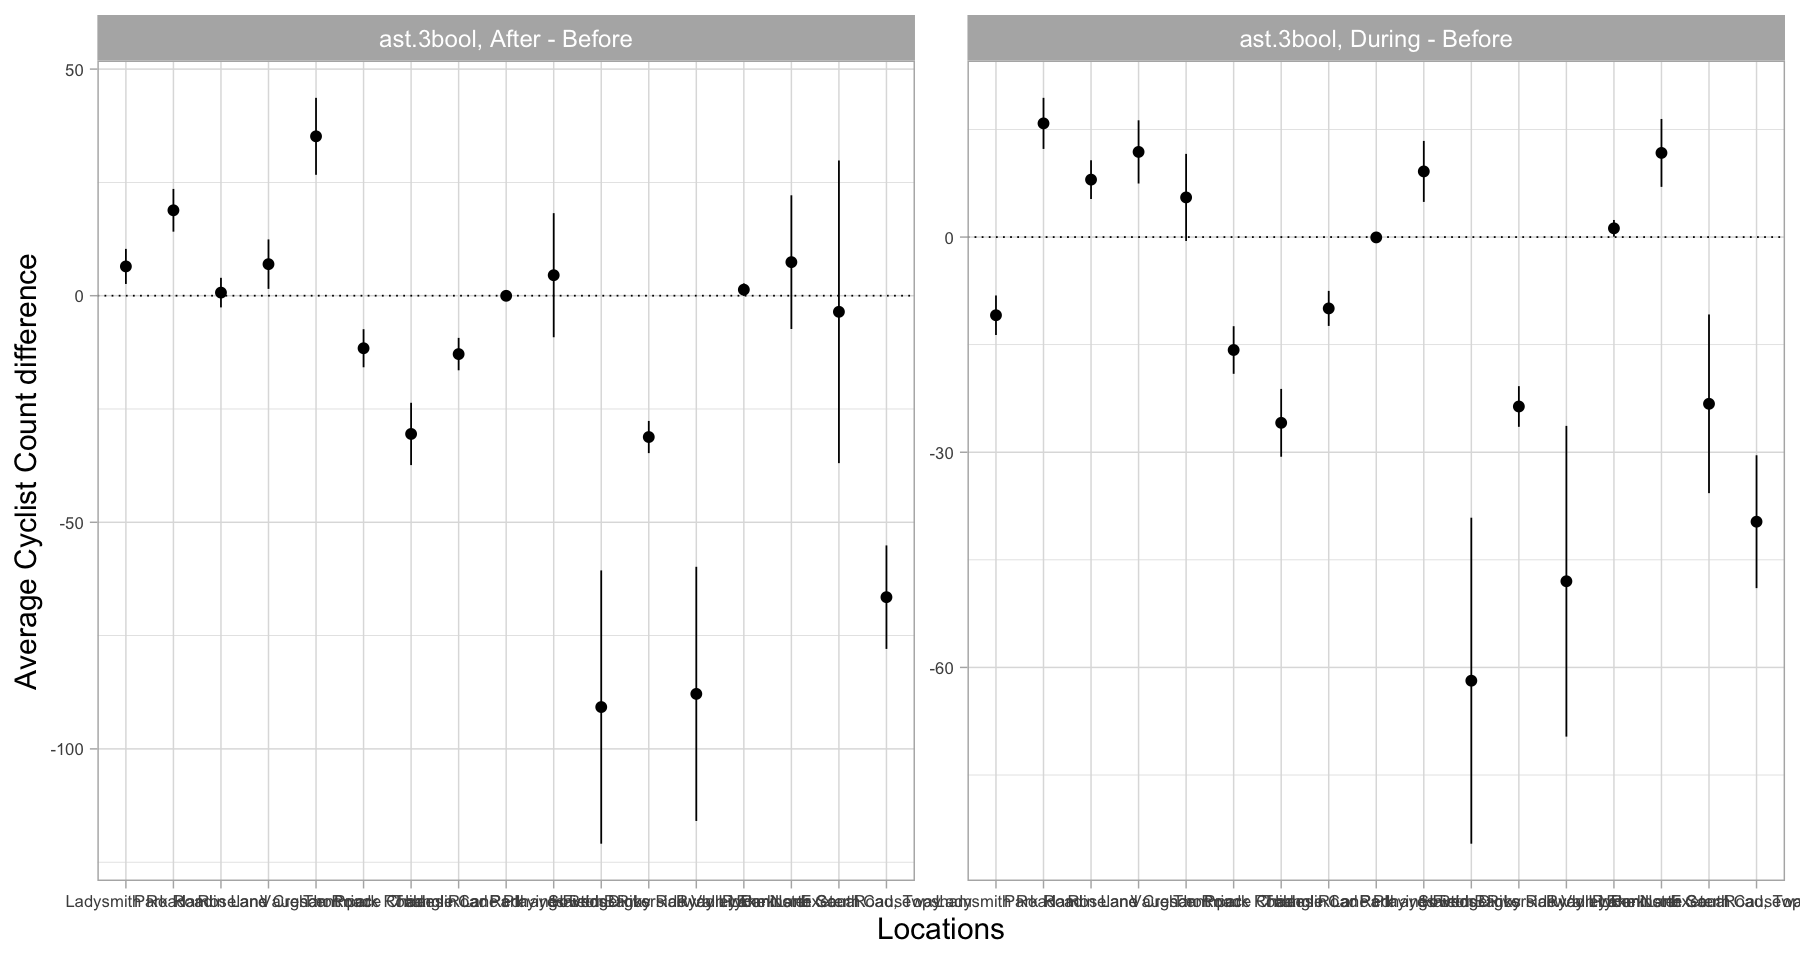

In [48]:
pc1 +
geom_hline(yintercept=0, linetype="dotted") + 
labs(x = "Locations", y = "Average Cyclist Count difference") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10))

## Rain Effect

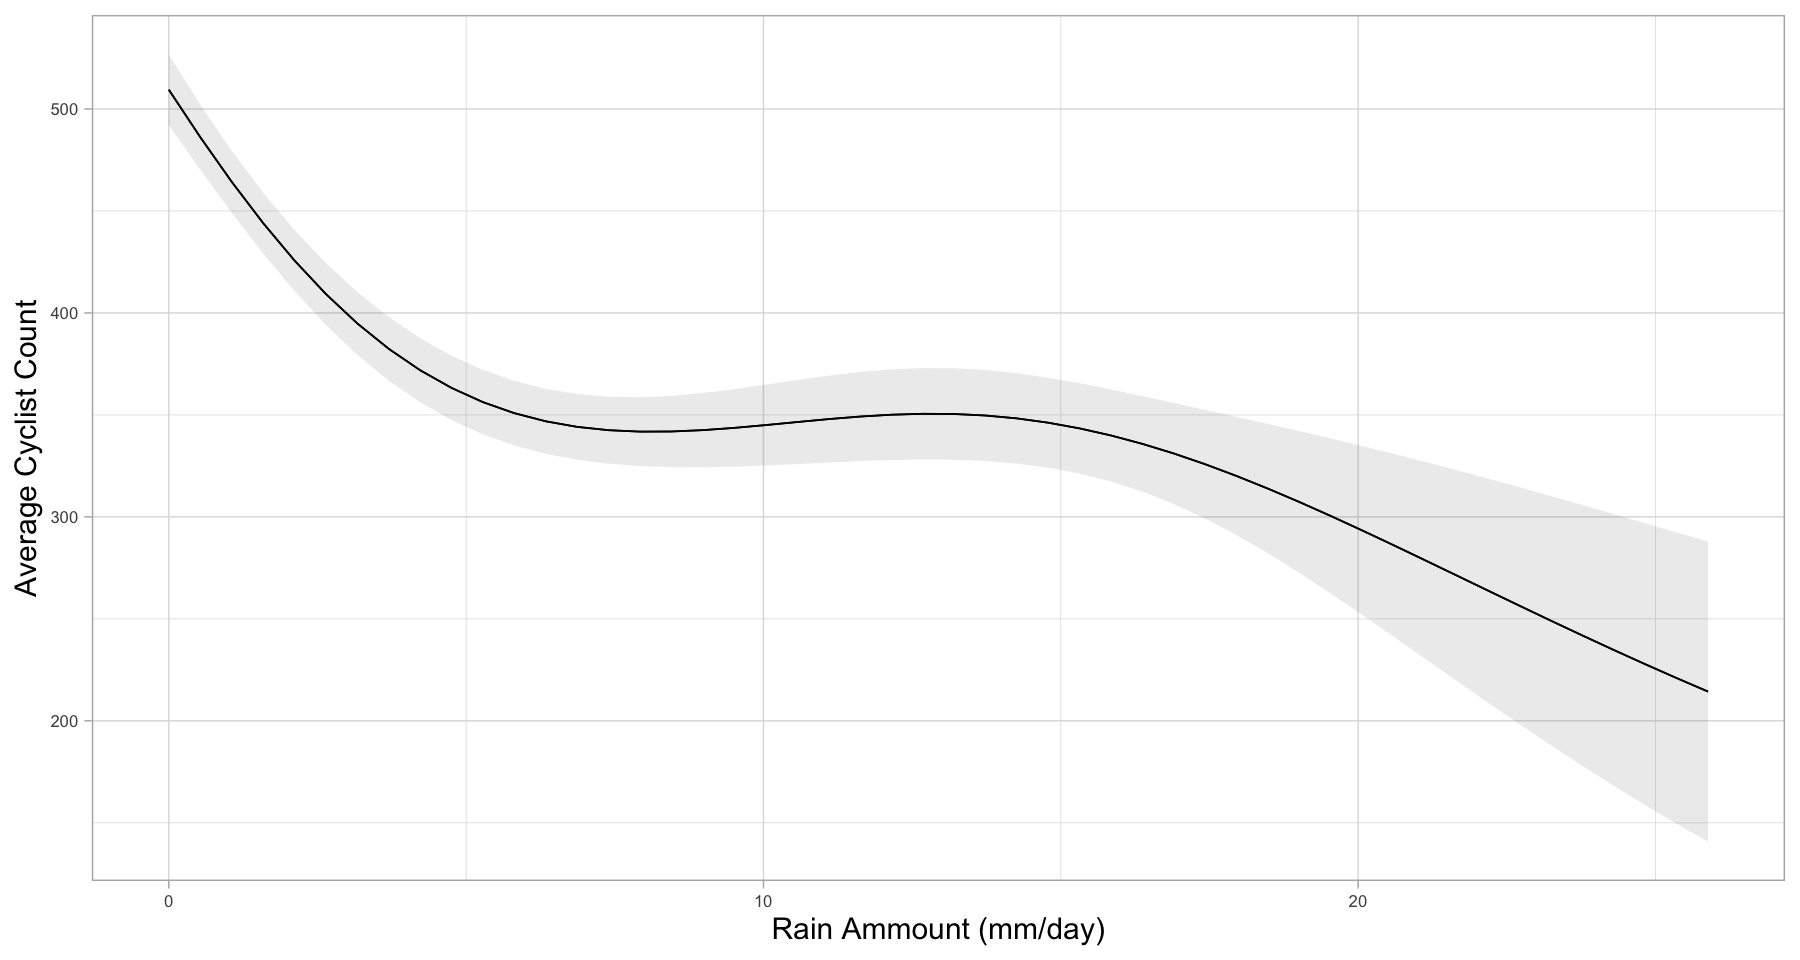

In [49]:
# Conditional (partial) effect
plot_predictions(nb.m5, condition = 'rain', type = 'response', vcov = TRUE,
newdata = datagrid(school.hol = as.factor(0), bankhol.bool = as.factor(0), weekday=c(1,2,3,4,5))) + 
labs(x = "Rain Ammount (mm/day)", y = "Average Cyclist Count") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10))

In [50]:
predictions(nb.m5, variables = list(rain=c(0, 26)), type = 'response', vcov = TRUE, newdata = 'mean')

rowid rowidcf estimate std.error statistic p.value      s.value  conf.low
1 1     1       509.4782  8.842462 57.617240 0.000000e+00      Inf 492.1473
2 2     1       212.9226 37.758213  5.639108 1.709333e-08 25.80199 138.9179
  conf.high df  location             weekday  ast.3bool school.hol bankhol.bool
1 526.8091  Inf Exeter Road, Topsham 4.004233 Before    0          0           
2 286.9274  Inf Exeter Road, Topsham 4.004233 Before    0          0           
  doy      count rain
1 182.4484 54     0  
2 182.4484 54    26

## Day of Week

In [59]:
plot_predictions(nb.m5, condition = list(weekday=seq(1,7)), type = 'response', vcov = TRUE,
newdata = datagrid(school.hol = as.factor(0), bankhol.bool = as.factor(0), rain=0), draw=FALSE)

rowid estimate std.error statistic p.value s.value conf.low conf.high df 
1 1     407.6405 8.955511  45.51839  0       Inf     390.0880 425.1929  Inf
2 2     425.9752 8.106974  52.54428  0       Inf     410.0858 441.8645  Inf
3 3     423.4155 8.014278  52.83265  0       Inf     407.7078 439.1232  Inf
4 4     410.6294 7.728962  53.12866  0       Inf     395.4809 425.7779  Inf
5 5     393.9058 7.429666  53.01796  0       Inf     379.3439 408.4677  Inf
6 6     374.5536 7.062390  53.03496  0       Inf     360.7116 388.3956  Inf
7 7     358.1103 7.808844  45.85958  0       Inf     342.8052 373.4153  Inf
  location             ast.3bool school.hol bankhol.bool rain     doy     
1 Exeter Road, Topsham Before    0          0            2.598167 182.4484
2 Exeter Road, Topsham Before    0          0            2.598167 182.4484
3 Exeter Road, Topsham Before    0          0            2.598167 182.4484
4 Exeter Road, Topsham Before    0          0            2.598167 182.4484
5 Exeter Road, Topsham Before    0          0            2.598167 182.4484
6 Exeter Road, Topsham Before    0          0            2.598167 182.4484
7 Exeter Road, Topsham Before    0          0            2.598167 182.4484
  weekday count
1 1       54   
2 2       54   
3 3       54   
4 4       54   
5 5       54   
6 6       54   
7 7       54

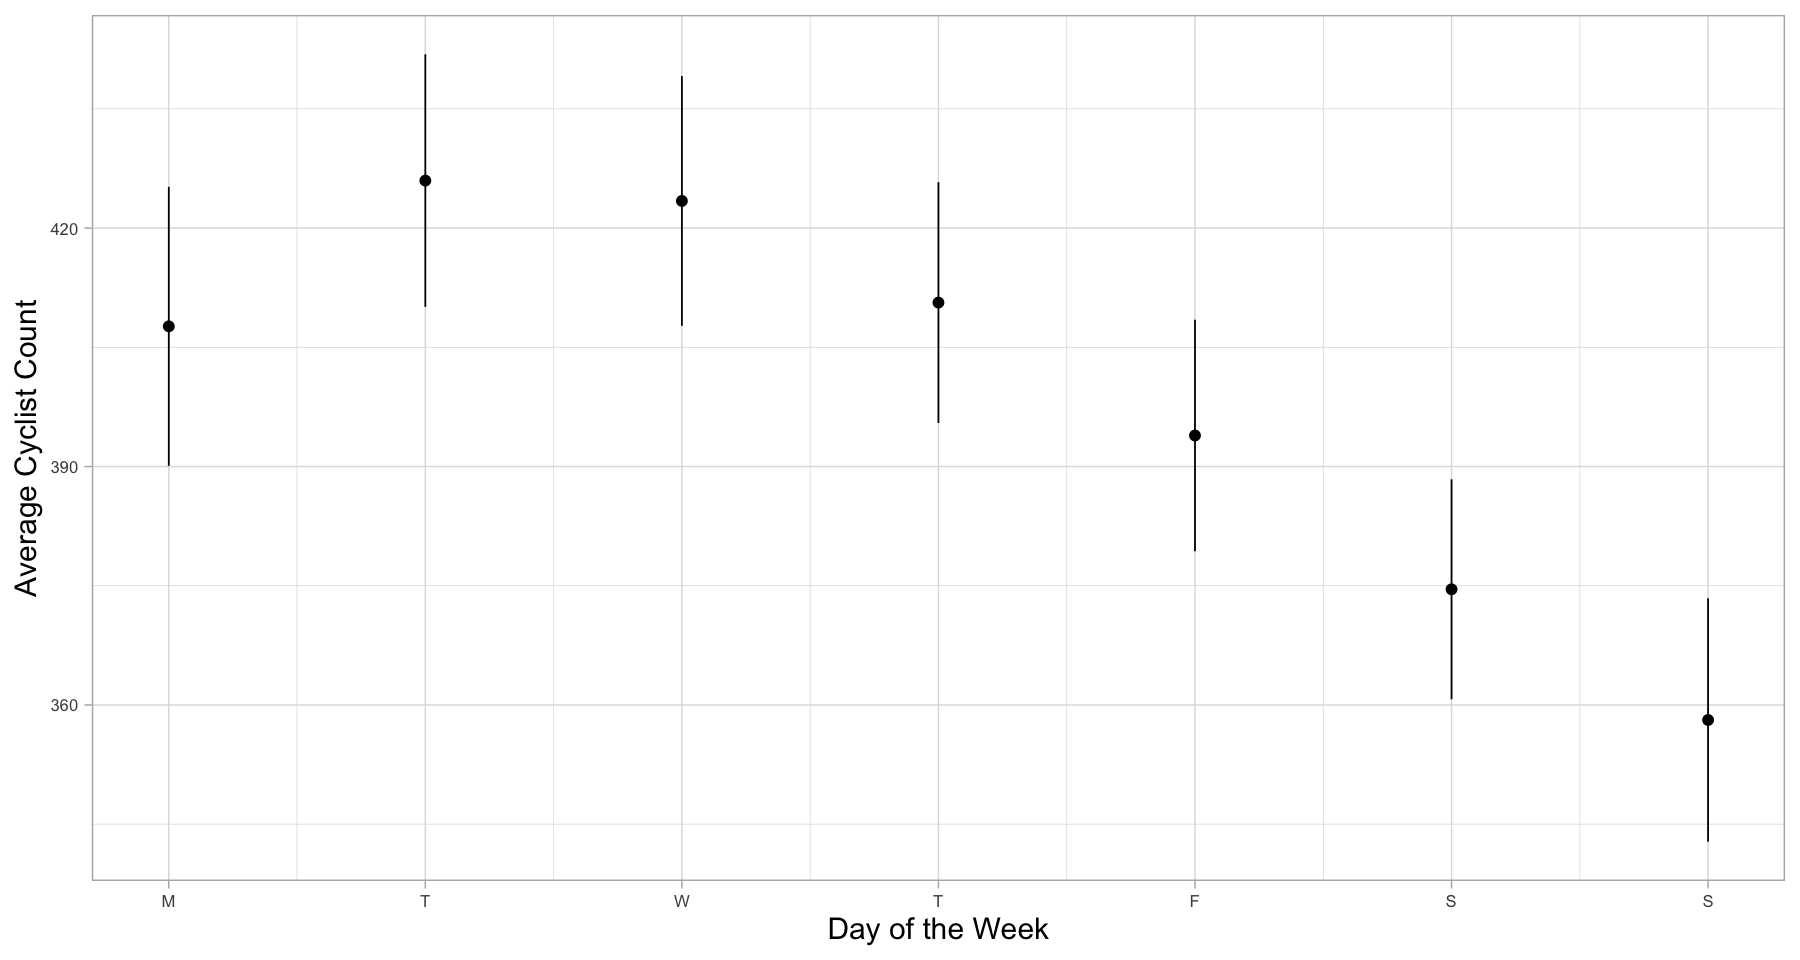

In [58]:
# Conditional (partial) effect
plot_predictions(nb.m5, condition = list(weekday=seq(1,7)), type = 'response', vcov = TRUE,
newdata = datagrid(school.hol = as.factor(0), bankhol.bool = as.factor(0), rain=0), draw=FALSE) |> 
ggplot() + geom_pointrange(aes(x=weekday, y=estimate, ymin=conf.low, ymax=conf.high)) + 
labs(x = "Day of the Week", y = "Average Cyclist Count") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10)) +
scale_x_continuous(breaks=seq(1,7),
        labels=c("M", "T", "W", "T", "F", "S", "S"))


## Day of Year effect

In [53]:
breaks = c(as.Date("2020-01-01"), 
        as.Date("2020-02-01"), 
        as.Date("2020-03-01"), 
        as.Date("2020-04-01"),
        as.Date("2020-05-01"),
        as.Date("2020-06-01"),
        as.Date("2020-07-01"),
        as.Date("2020-08-01"),
        as.Date("2020-09-01"),
        as.Date("2020-10-01"),
        as.Date("2020-11-01"),
        as.Date("2020-12-01"))

In [54]:
pred.doy <- plot_predictions(nb.m5, condition = list(doy=seq(1,365), 'location'), type = 'response', vcov = TRUE, draw=FALSE,
newdata = 'mean')

In [55]:
pred.doy %>% group_by(location) %>% filter(estimate == min(estimate))

rowid estimate  std.error  statistic p.value       s.value   conf.low 
1  6155   68.59185  2.0201345 33.95410  1.061082e-252  837.0403  64.63246
2  6156   72.52329  2.0540495 35.30747  4.510246e-273  904.7132  68.49743
3  6157   60.59894  1.7406273 34.81442  1.471618e-265  879.7535  57.18737
4  6158  108.42869  3.0228524 35.86966  9.081038e-282  933.6009 102.50401
5  6159  150.82442  4.2399110 35.57254  3.724606e-277  918.2770 142.51435
6  6160   88.21345  2.4765107 35.62006  6.854881e-278  920.7189  83.35958
7  6161  126.43460  3.1005732 40.77781   0.000000e+00       Inf 120.35759
8  6162   60.58667  1.5089141 40.15250   0.000000e+00       Inf  57.62925
9  6163   95.40136  2.5686094 37.14125  6.069734e-302 1000.6207  90.36698
10 6164  106.28934  2.7487148 38.66874   0.000000e+00       Inf 100.90196
11 6165  556.38547 11.7615622 47.30541   0.000000e+00       Inf 533.33323
12 6166   83.35344  2.2230508 37.49507  1.108302e-307 1019.6836  78.99634
13 6167  474.83778 10.1085096 46.97406   0.000000e+00       Inf 455.02546
14 6168   26.97798  0.7000762 38.53577   0.000000e+00       Inf  25.60585
15 6169  116.29802  3.0671417 37.91739  1.330434e-314 1042.6735 110.28653
16 6170  200.55032  5.1647319 38.83073   0.000000e+00       Inf 190.42763
17 6171  221.10349  4.4112806 50.12229   0.000000e+00       Inf 212.45754
   conf.high df  weekday  ast.3bool school.hol bankhol.bool rain     doy
1   72.55124 Inf 4.004233 Before    0          0            2.598167 363
2   76.54915 Inf 4.004233 Before    0          0            2.598167 363
3   64.01050 Inf 4.004233 Before    0          0            2.598167 363
4  114.35338 Inf 4.004233 Before    0          0            2.598167 363
5  159.13449 Inf 4.004233 Before    0          0            2.598167 363
6   93.06732 Inf 4.004233 Before    0          0            2.598167 363
7  132.51161 Inf 4.004233 Before    0          0            2.598167 363
8   63.54409 Inf 4.004233 Before    0          0            2.598167 363
9  100.43574 Inf 4.004233 Before    0          0            2.598167 363
10 111.67672 Inf 4.004233 Before    0          0            2.598167 363
11 579.43771 Inf 4.004233 Before    0          0            2.598167 363
12  87.71054 Inf 4.004233 Before    0          0            2.598167 363
13 494.65009 Inf 4.004233 Before    0          0            2.598167 363
14  28.35010 Inf 4.004233 Before    0          0            2.598167 363
15 122.30950 Inf 4.004233 Before    0          0            2.598167 363
16 210.67301 Inf 4.004233 Before    0          0            2.598167 363
17 229.74944 Inf 4.004233 Before    0          0            2.598167 363
   location                   count
1  Ladysmith Road             54   
2  Park Road                  54   
3  Hamlin Lane                54   
4  Roseland Crescent          54   
5  Vaughan Road               54   
6  Thornpark Road             54   
7  Prince Charles Road        54   
8  Triangle Car Park          54   
9  Hamlin Lane Playing Fields 54   
10 Redhayes Bridge            54   
11 Haven Banks                54   
12 Sowton Digby Railway Link  54   
13 Riverside Valley Park      54   
14 Rydon Lane North           54   
15 Rydon Lane South           54   
16 Exminster Canal Causeway   54   
17 Exeter Road, Topsham       54

In [56]:
pred.doy %>% group_by(location) %>% filter(estimate == max(estimate))

rowid estimate  std.error statistic p.value       s.value   conf.low  
1  2500   141.6953  4.110455 34.47192  2.114361e-260  862.6211  133.63893
2  2501   149.8167  4.184483 35.80293  9.943987e-281  930.1480  141.61530
3  2502   125.1837  3.550216 35.26088  2.337330e-272  902.3396  118.22542
4  2503   223.9892  6.146304 36.44291  8.909821e-291  963.5257  211.94266
5  2504   311.5692  8.650340 36.01814  4.350476e-284  941.3064  294.61484
6  2505   182.2291  5.047343 36.10396  1.965535e-285  945.7746  172.33646
7  2506   261.1853  6.272756 41.63805   0.000000e+00       Inf  248.89095
8  2507   125.1584  3.041369 41.15198   0.000000e+00       Inf  119.19740
9  2508   197.0777  5.184392 38.01365  3.433977e-316 1047.9494  186.91644
10 2509   219.5698  5.565890 39.44918   0.000000e+00       Inf  208.66083
11 2510  1149.3667 23.579301 48.74473   0.000000e+00       Inf 1103.15215
12 2511   172.1894  4.503063 38.23828  6.514750e-320 1060.3133  163.36354
13 2512   980.9076 20.336134 48.23471   0.000000e+00       Inf  941.04952
14 2513    55.7304  1.416981 39.33038   0.000000e+00       Inf   52.95317
15 2514   240.2454  6.224520 38.59662   0.000000e+00       Inf  228.04560
16 2515   414.2917 10.346067 40.04340   0.000000e+00       Inf  394.01375
17 2516   456.7499  8.854384 51.58461   0.000000e+00       Inf  439.39561
   conf.high  df  weekday  ast.3bool school.hol bankhol.bool rain     doy
1   149.75162 Inf 4.004233 Before    0          0            2.598167 148
2   158.01817 Inf 4.004233 Before    0          0            2.598167 148
3   132.14201 Inf 4.004233 Before    0          0            2.598167 148
4   236.03573 Inf 4.004233 Before    0          0            2.598167 148
5   328.52355 Inf 4.004233 Before    0          0            2.598167 148
6   192.12168 Inf 4.004233 Before    0          0            2.598167 148
7   273.47970 Inf 4.004233 Before    0          0            2.598167 148
8   131.11935 Inf 4.004233 Before    0          0            2.598167 148
9   207.23888 Inf 4.004233 Before    0          0            2.598167 148
10  230.47872 Inf 4.004233 Before    0          0            2.598167 148
11 1195.58131 Inf 4.004233 Before    0          0            2.598167 148
12  181.01523 Inf 4.004233 Before    0          0            2.598167 148
13 1020.76570 Inf 4.004233 Before    0          0            2.598167 148
14   58.50764 Inf 4.004233 Before    0          0            2.598167 148
15  252.44527 Inf 4.004233 Before    0          0            2.598167 148
16  434.56959 Inf 4.004233 Before    0          0            2.598167 148
17  474.10415 Inf 4.004233 Before    0          0            2.598167 148
   location                   count
1  Ladysmith Road             54   
2  Park Road                  54   
3  Hamlin Lane                54   
4  Roseland Crescent          54   
5  Vaughan Road               54   
6  Thornpark Road             54   
7  Prince Charles Road        54   
8  Triangle Car Park          54   
9  Hamlin Lane Playing Fields 54   
10 Redhayes Bridge            54   
11 Haven Banks                54   
12 Sowton Digby Railway Link  54   
13 Riverside Valley Park      54   
14 Rydon Lane North           54   
15 Rydon Lane South           54   
16 Exminster Canal Causeway   54   
17 Exeter Road, Topsham       54

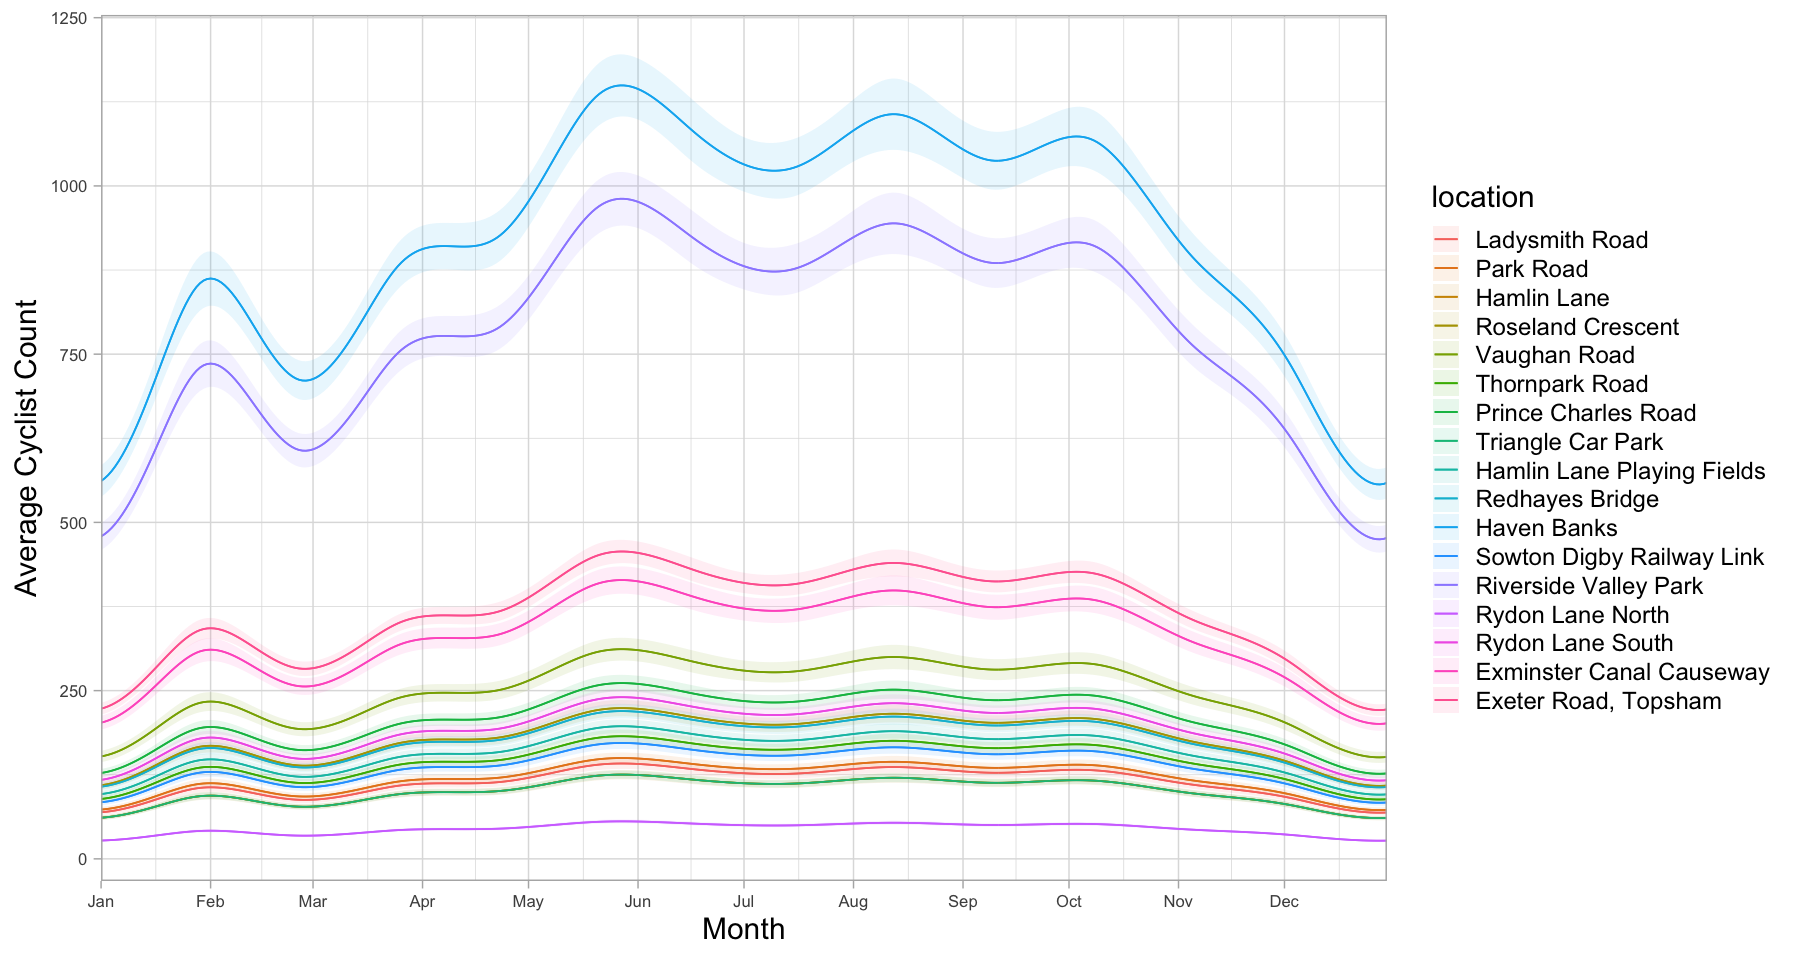

In [60]:
plot_predictions(nb.m5, condition = list(doy=seq(1,365), 'location'), type = 'response', newdata='mean', vcov = TRUE) +
labs(x = "Month", y = "Average Cyclist Count") + 
theme_light(base_size = 18) +
theme(axis.text = element_text(size = 10)) +
scale_x_continuous(breaks=yday(breaks),
        labels=month(breaks, label=TRUE),
        limits = c(1, 365), expand=c(0,0))

## Model Residuals

Plot of unexplained variation in data

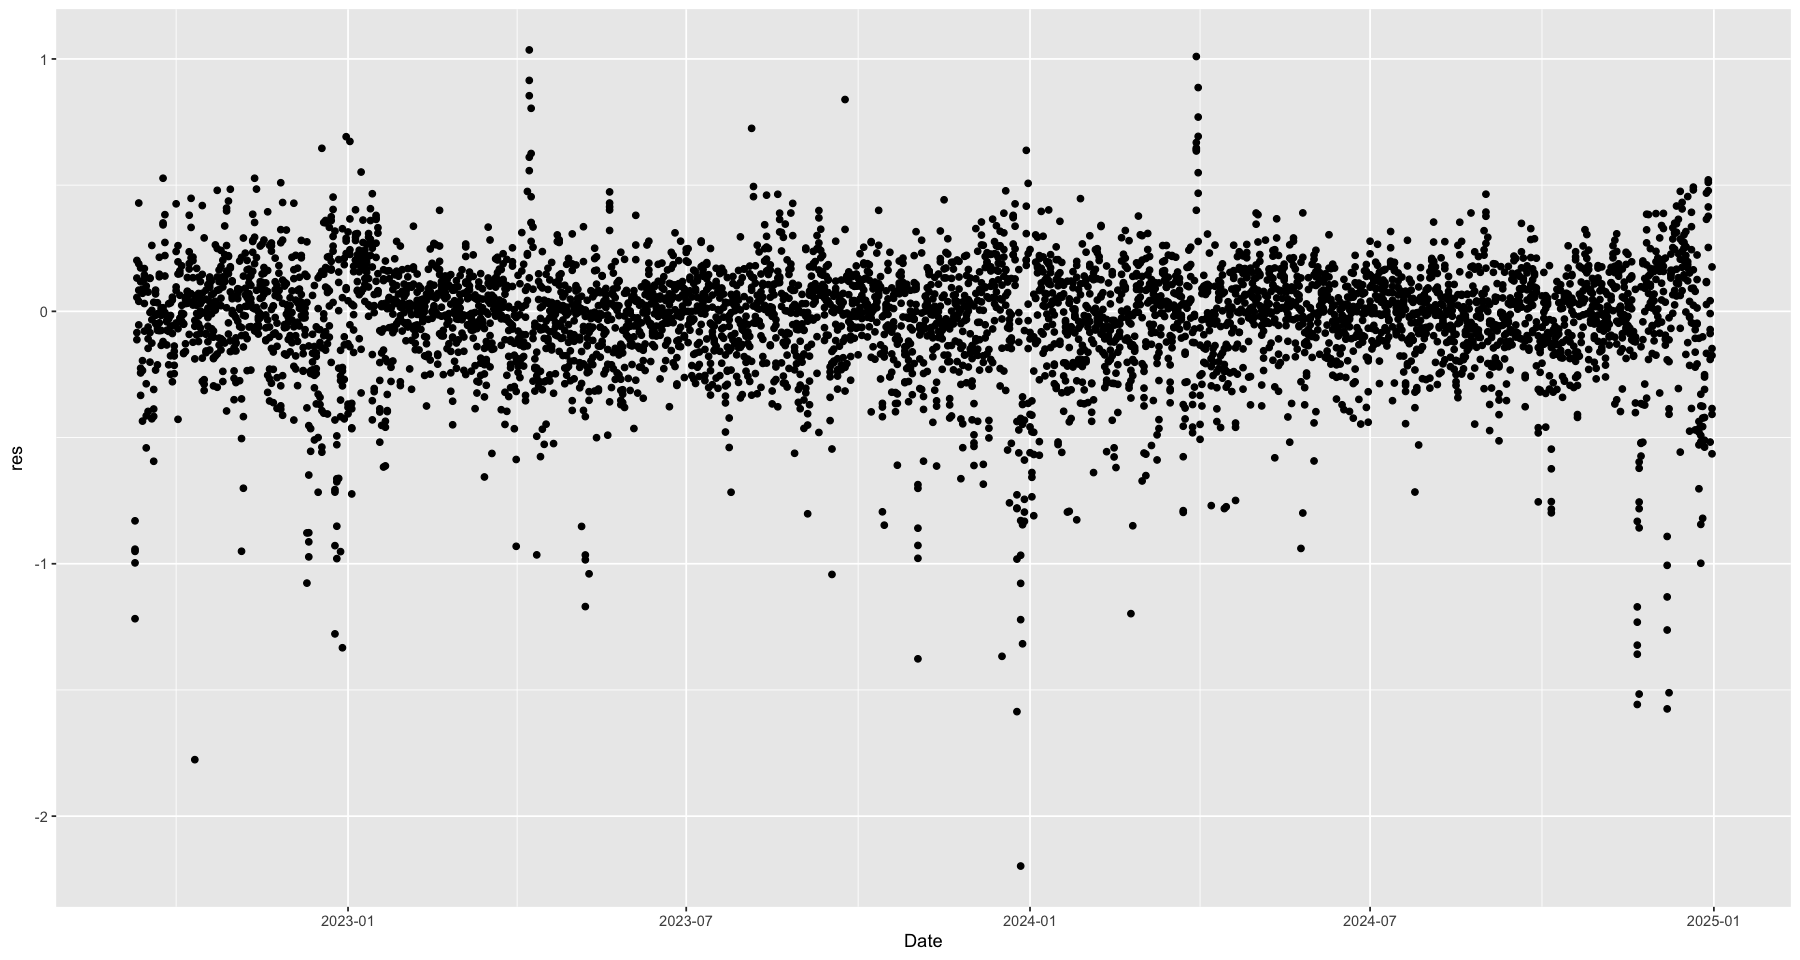

In [195]:
ggplot(data=df2 %>% mutate(res = nb.m5$residuals), aes(x=Date, y=res)) + geom_point()

In [322]:
df %>% filter(mode == 'Cyclist') %>% mutate(res = nb.m1$residuals)

Date       weekday doy ast.3bool ast.2bool location       school.hol year
1    2022-09-10 6       253 Before    No        Ladysmith Road 0          0   
2    2022-09-11 7       254 Before    No        Ladysmith Road 0          0   
3    2022-09-12 1       255 Before    No        Ladysmith Road 0          0   
4    2022-09-13 2       256 Before    No        Ladysmith Road 0          0   
5    2022-09-14 3       257 Before    No        Ladysmith Road 0          0   
6    2022-09-15 4       258 Before    No        Ladysmith Road 0          0   
7    2022-09-16 5       259 Before    No        Ladysmith Road 0          0   
8    2022-09-17 6       260 Before    No        Ladysmith Road 0          0   
9    2022-09-18 7       261 Before    No        Ladysmith Road 0          0   
10   2022-09-19 1       262 Before    No        Ladysmith Road 0          0   
11   2022-09-20 2       263 Before    No        Ladysmith Road 0          0   
12   2022-09-21 3       264 Before    No        Ladysmith Road 0          0   
13   2022-09-22 4       265 Before    No        Ladysmith Road 0          0   
14   2022-09-23 5       266 Before    No        Ladysmith Road 0          0   
15   2022-09-24 6       267 Before    No        Ladysmith Road 0          0   
16   2022-09-25 7       268 Before    No        Ladysmith Road 0          0   
17   2022-09-26 1       269 Before    No        Ladysmith Road 0          0   
18   2022-09-27 2       270 Before    No        Ladysmith Road 0          0   
19   2022-09-28 3       271 Before    No        Ladysmith Road 0          0   
20   2022-09-29 4       272 Before    No        Ladysmith Road 0          0   
21   2022-09-30 5       273 Before    No        Ladysmith Road 0          0   
22   2022-10-01 6       274 Before    No        Ladysmith Road 0          0   
23   2022-10-02 7       275 Before    No        Ladysmith Road 0          0   
24   2022-10-03 1       276 Before    No        Ladysmith Road 0          0   
25   2022-10-04 2       277 Before    No        Ladysmith Road 0          0   
26   2022-10-05 3       278 Before    No        Ladysmith Road 0          0   
27   2022-10-06 4       279 Before    No        Ladysmith Road 0          0   
28   2022-10-07 5       280 Before    No        Ladysmith Road 0          0   
29   2022-10-08 6       281 Before    No        Ladysmith Road 0          0   
30   2022-10-09 7       282 Before    No        Ladysmith Road 0          0   
⋮    ⋮          ⋮       ⋮   ⋮         ⋮         ⋮              ⋮          ⋮   
3718 2024-12-02 1       337 After     No        Thornpark Road 0          2   
3719 2024-12-03 2       338 After     No        Thornpark Road 0          2   
3720 2024-12-04 3       339 After     No        Thornpark Road 0          2   
3721 2024-12-05 4       340 After     No        Thornpark Road 0          2   
3722 2024-12-06 5       341 After     No        Thornpark Road 0          2   
3723 2024-12-07 6       342 After     No        Thornpark Road 0          2   
3724 2024-12-08 7       343 After     No        Thornpark Road 0          2   
3725 2024-12-09 1       344 After     No        Thornpark Road 0          2   
3726 2024-12-10 2       345 After     No        Thornpark Road 0          2   
3727 2024-12-11 3       346 After     No        Thornpark Road 0          2   
3728 2024-12-12 4       347 After     No        Thornpark Road 0          2   
3729 2024-12-13 5       348 After     No        Thornpark Road 0          2   
3730 2024-12-14 6       349 After     No        Thornpark Road 0          2   
3731 2024-12-15 7       350 After     No        Thornpark Road 0          2   
3732 2024-12-16 1       351 After     No        Thornpark Road 0          2   
3733 2024-12-17 2       352 After     No        Thornpark Road 0          2   
3734 2024-12-18 3       353 After     No        Thornpark Road 0          2   
3735 2024-12-19 4       354 After     No        Thornpark Road 0          2   
3736 2024-12-20 5       355 After     No        Thornpa

In [95]:
avg_predictions(nb.m3, variables = 'weekday', 
newdata = datagrid(school.hol = as.factor(0), bankhol.bool = as.factor(0), weekday=seq(1,7), rain=0),
type = 'response', vcov=TRUE)

weekday estimate  std.error statistic p.value       s.value  conf.low 
1 1       115.80309 4.291760  26.98266  2.361723e-160 530.2687 107.39139
2 2       122.15717 4.492121  27.19365  7.721177e-163 538.5255 113.35277
3 4       124.16167 4.563401  27.20815  5.202225e-163 539.0952 115.21757
4 6        54.86254 2.119495  25.88473  9.895803e-148 488.3385  50.70841
5 7        48.41092 1.903433  25.43347  1.075646e-142 471.6086  44.68026
  conf.high
1 124.21478
2 130.96156
3 133.10577
4  59.01668
5  52.14158

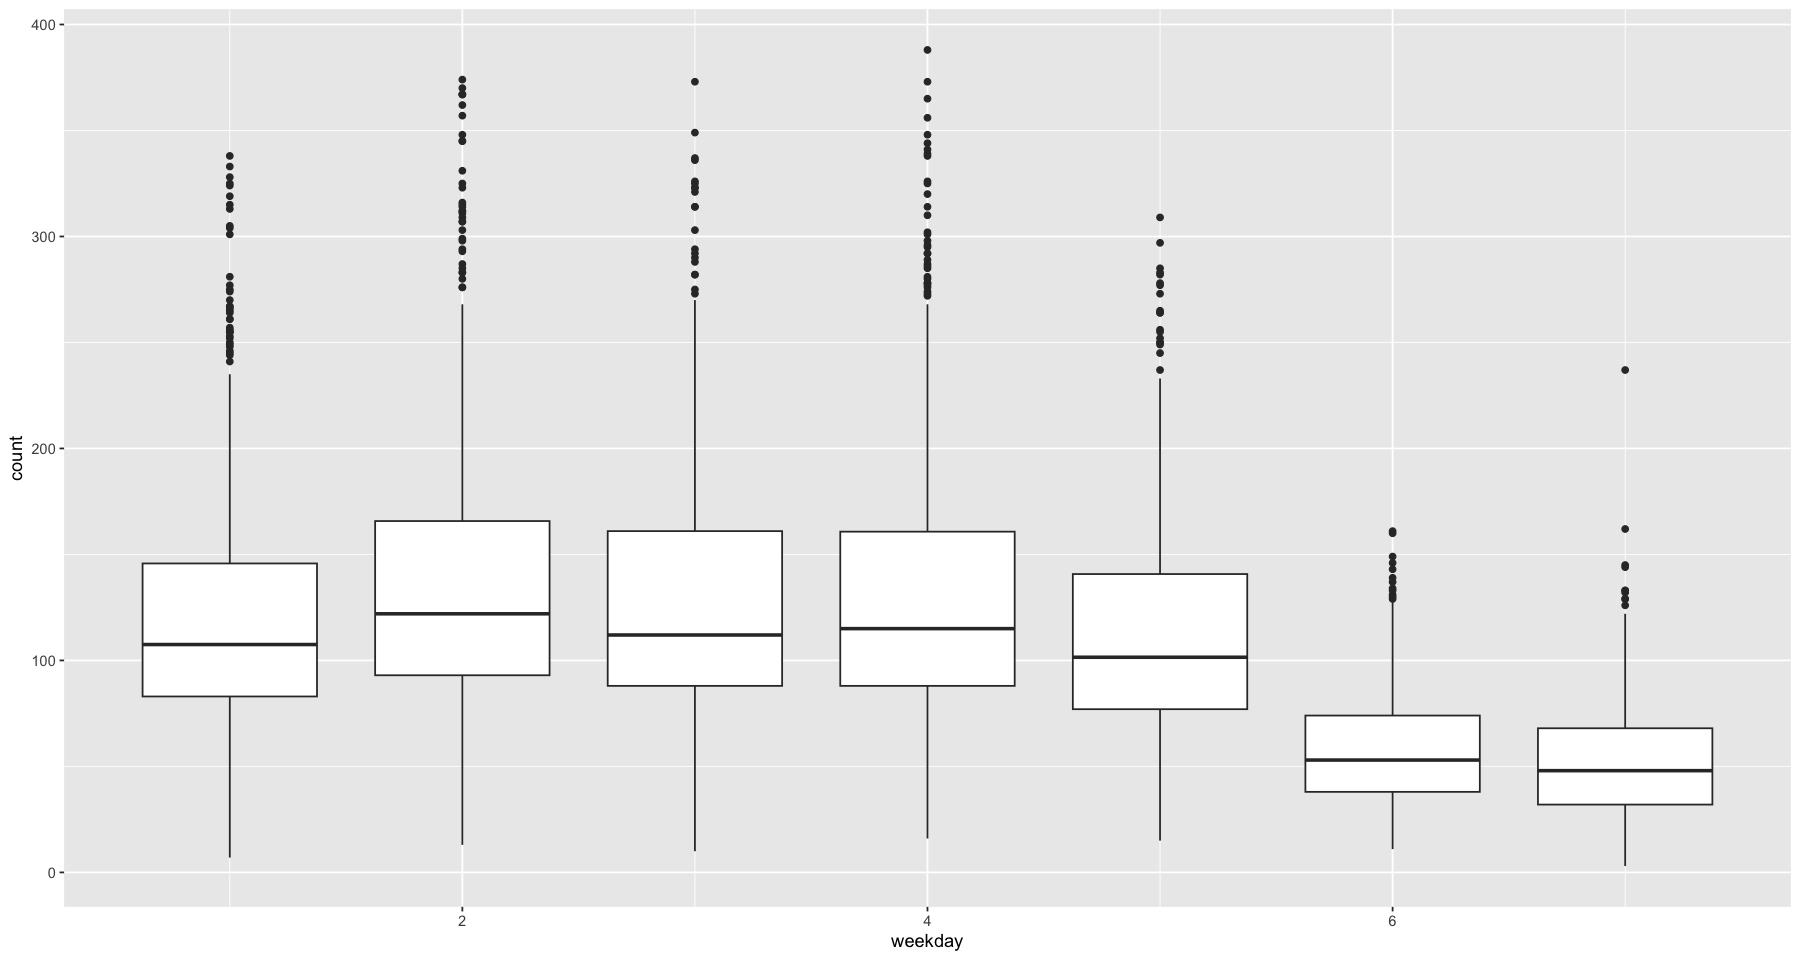

In [99]:
ggplot(data=df %>% filter(mode == "Cyclist"), aes(x=weekday, y=count, group=weekday)) + geom_boxplot()

In [311]:
nb.m2 <- gamm(count ~ s(location, bs="re") + 
                s(weekday, location, bs='fs', xt=list(bs="ts"), k=7) + 
                s(ast.3bool, bs='re') + 
                s(school.hol, bs='re')+
                s(doy, bs = 'cc', k=12)+
                s(rain, k=5, bs='ts'),
            data = df %>% filter(mode=='Cyclist'),
            family = nb, method='REML',
            correlation = corARMA(form = ~ doy, p=3))

ERROR: Error in `[<-`(`*tmp*`, object$rank + i, object$rank + i, value = 1): subscript out of bounds


In [170]:
summary(nb.m2$gam)


Family: negative binomial 
Link function: log 

Formula:
count ~ s(location, bs = "re") + s(weekday, location, bs = "fs", 
    xt = list(bs = "cr"), k = 7) + s(ast.bool, bs = "re") + s(school.hol, 
    bs = "re") + s(doy, bs = "cc", k = 12)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    4.433      0.206   21.52   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df      F p-value    
s(location)          0.001342      5   0.00  <2e-16 ***
s(weekday,location) 39.223788     41 225.78  <2e-16 ***
s(ast.bool)          1.971890      2  57.28  <2e-16 ***
s(school.hol)        0.998070      1 785.50  <2e-16 ***
s(doy)               9.682227     10 469.50  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =   0.84   
  Scale est. = 0.068613  n = 3747

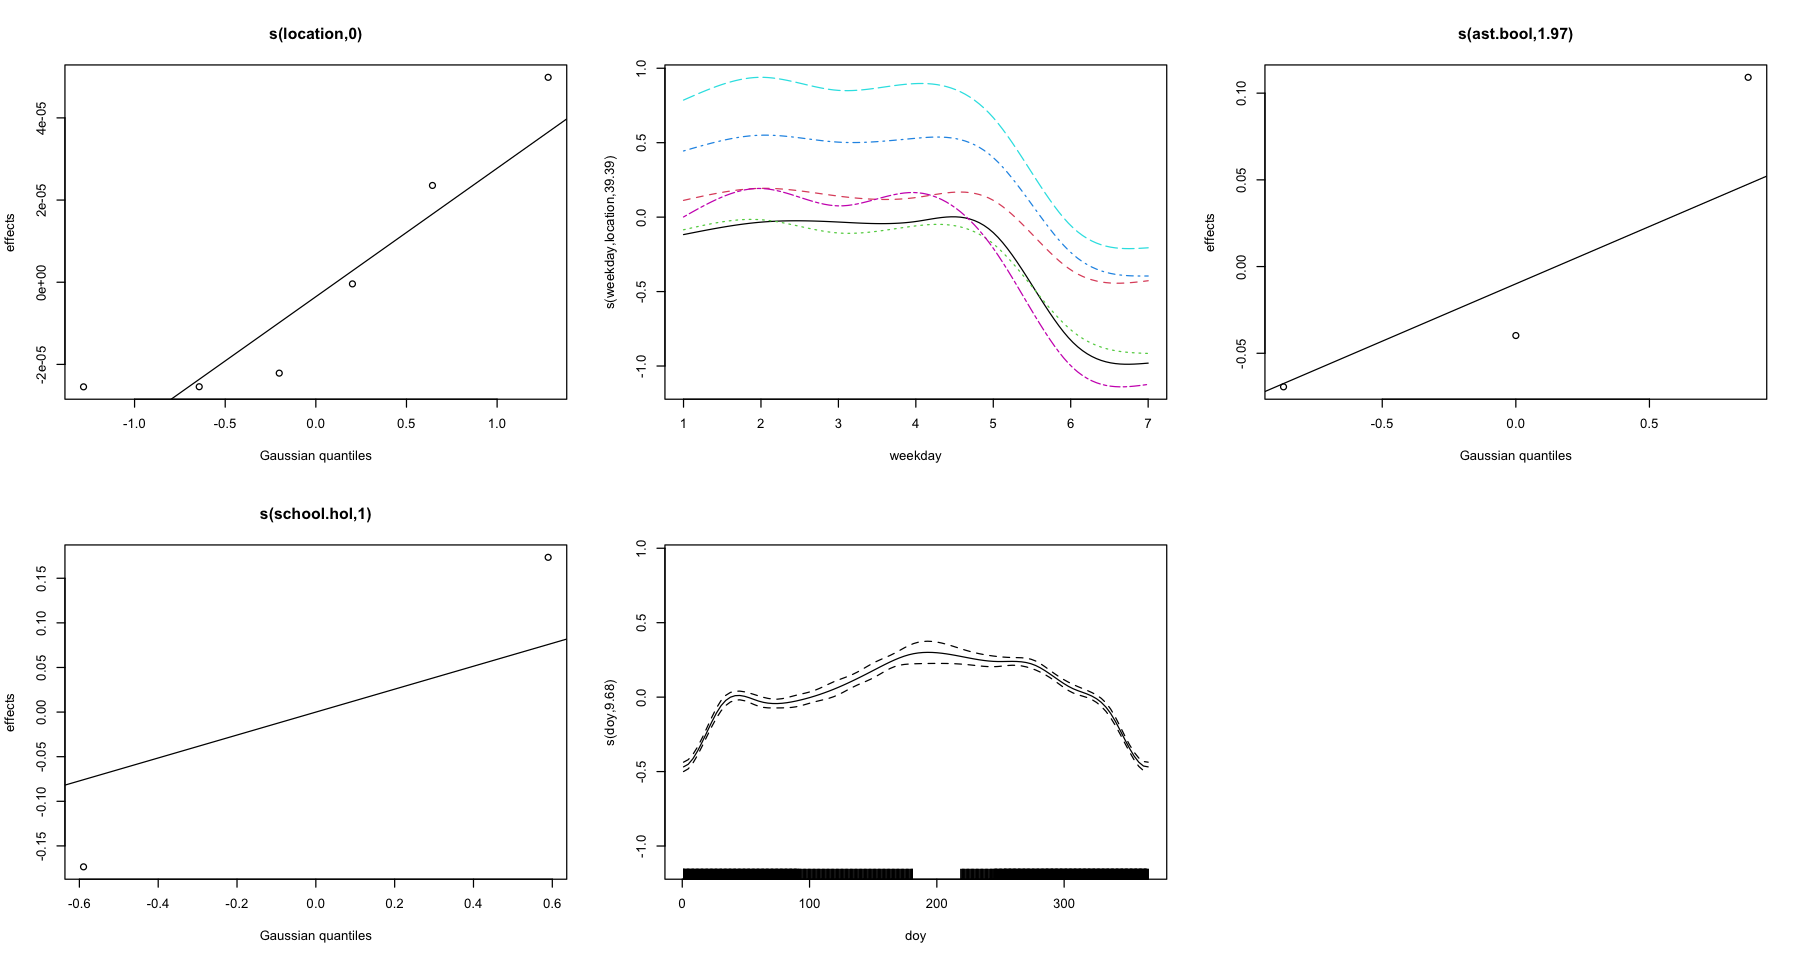

In [148]:
par(bg = "white")
plot(nb.m2$gam, pages=1)

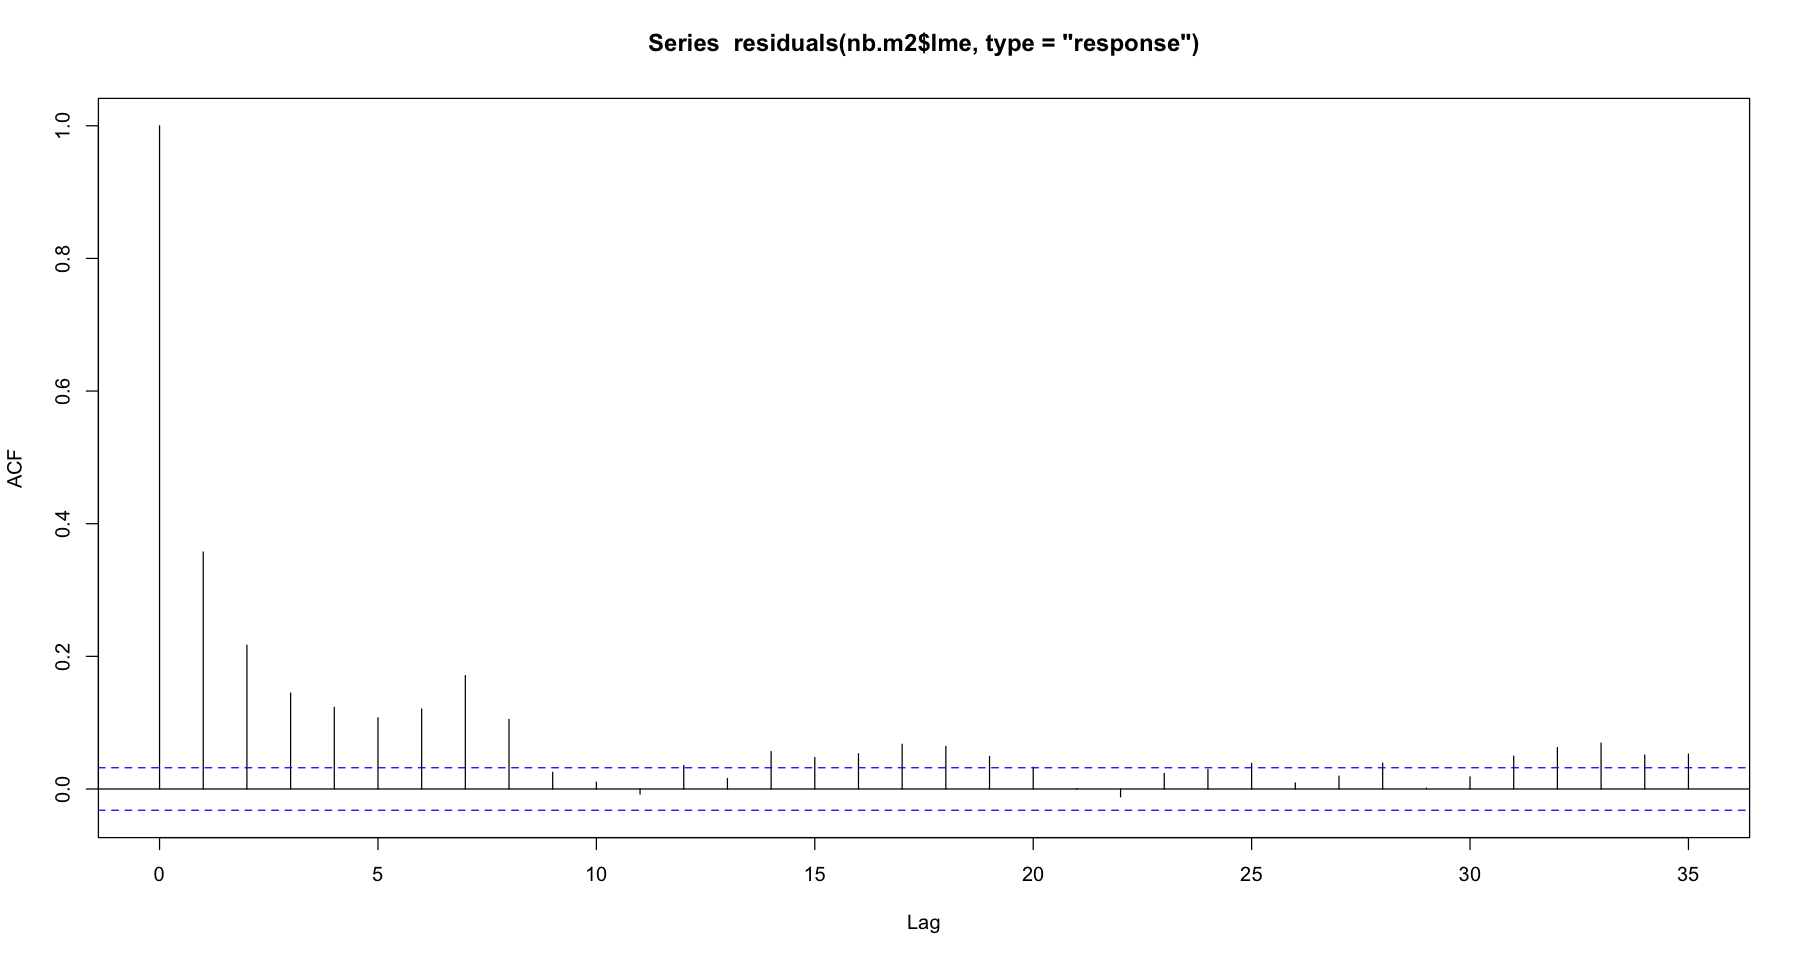

In [163]:
par(bg = "white")
acf(residuals(nb.m2$lme, type = 'response'))

In [160]:
coef(nb.m2$lme$modelStruct$corStruct, unconstrained = F)

Phi1        Phi2        Phi3 
0.192692077 0.039500336 0.006151291